In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, Dense, MaxPool2D, LeakyReLU, Reshape, Dropout, Flatten, GaussianNoise, Embedding, multiply, concatenate
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import time

In [3]:
def normalize_img(img):
    return (img - 127.5)/127.5

def unnormalize_img(img):
    return (img + 1.) / 2.

In [5]:
img_classes = ['chihuahua', 'chimpanzee', 'dalmatian', 'dolphin', 'fox', 'giant+panda', 'giraffe', 'otter', 'polar+bear', 'zebra']
min_images = float('inf')
for root, dirs, files in os.walk("./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/", topdown=False):
    if any(x in root for x in img_classes):
        min_images = min(min_images, len(files))
print('Minimum images across all included classes is:', min_images)

Minimum images across all included classes is: 549


1046 samples in class 0, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/antelope)
383 samples in class 0, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/bat)
193 samples in class 0, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/beaver)
174 samples in class 0, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/blue+whale)
630 samples in class 0, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/bobcat)
895 samples in class 0, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/buffalo)
567 samples in class 0, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/chihuahua)


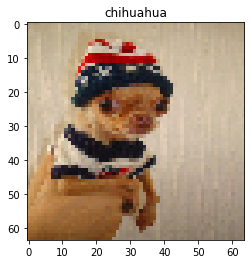

728 samples in class 1, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/chimpanzee)


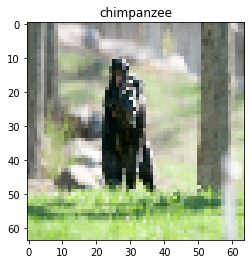

1028 samples in class 2, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/collie)
1338 samples in class 2, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/cow)
549 samples in class 2, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/dalmatian)


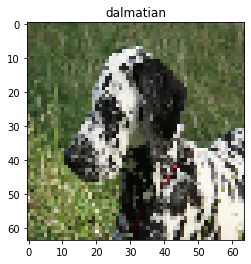

1344 samples in class 3, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/deer)
946 samples in class 3, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/dolphin)


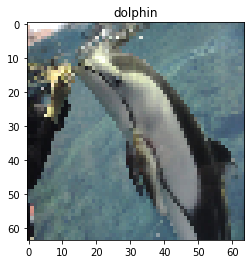

1038 samples in class 4, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/elephant)
664 samples in class 4, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/fox)


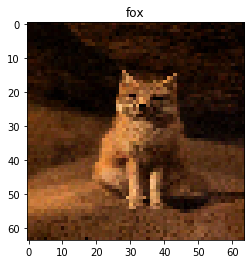

1033 samples in class 5, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/german+shepherd)
874 samples in class 5, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/giant+panda)


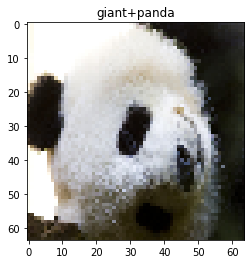

1202 samples in class 6, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/giraffe)


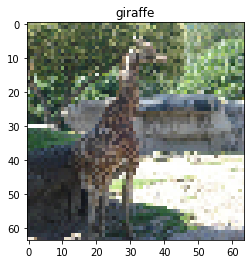

872 samples in class 7, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/gorilla)
852 samples in class 7, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/grizzly+bear)
779 samples in class 7, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/hamster)
684 samples in class 7, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/hippopotamus)
1645 samples in class 7, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/horse)
709 samples in class 7, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/humpback+whale)
291 samples in class 7, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/killer+whale)
720 samples in class 7, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/leopard)
1019 samples in class 7, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/lion)
100 samples in class 7, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/mole)
704 samples in class 7, (./AwA2/AwA2-data/An

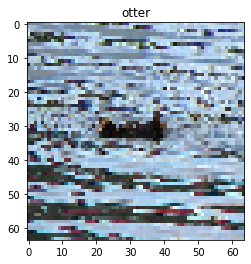

728 samples in class 8, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/ox)
747 samples in class 8, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/persian+cat)
713 samples in class 8, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/pig)
868 samples in class 8, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/polar+bear)


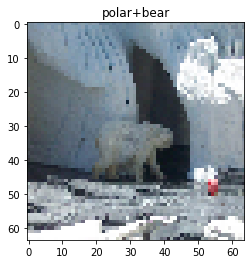

1088 samples in class 9, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/rabbit)
512 samples in class 9, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/raccoon)
310 samples in class 9, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/rat)
696 samples in class 9, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/rhinoceros)
988 samples in class 9, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/seal)
1420 samples in class 9, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/sheep)
500 samples in class 9, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/siamese+cat)
188 samples in class 9, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/skunk)
291 samples in class 9, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/spider+monkey)
1200 samples in class 9, (./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/squirrel)
877 samples in class 9, (./AwA2/AwA2-data/Animals_with_

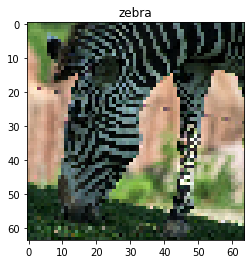

In [6]:
train_imgs = []
train_classes = []
class_index = 0
import os
for root, dirs, files in os.walk("./AwA2/AwA2-data/Animals_with_Attributes2/JPEGImagesCleaned/", topdown=False):
    print(f'{len(files)} samples in class {class_index}, ({root})')
    if any(x in root for x in img_classes):
        for name in files[:min_images]:
            train_imgs.append(cv2.cvtColor(cv2.imread(os.path.join(root, name)), cv2.COLOR_RGB2BGR))
            train_classes.append(class_index)
        plt.imshow(train_imgs[-1])
        plt.title(img_classes[class_index])
        plt.show()
        class_index += 1
    if class_index >= 10:
        break
train_imgs = np.array(train_imgs)
train_imgs = (train_imgs - 127.5)/127.5
train_classes = np.array(train_classes, dtype=np.float32)

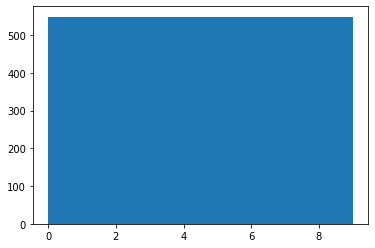

In [7]:
plt.hist(train_classes, bins=10)
plt.show()
assert(len(train_imgs) == len(train_classes))

In [8]:
def make_generator_model(shape):
    
    noise_in = Input(shape=shape)
    label_in = Input(shape=(1,))
    label_embedding = Embedding(10, 100)(label_in)
    
    input_layer = multiply([noise_in, label_embedding])
    
    x = Dense(16*16*64*4)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Reshape((16, 16, 256))(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(256, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    
    return Model([noise_in, label_in], x)

In [9]:
generator = make_generator_model((100,))
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1000        input_2[0][0]                    
__________________________________________________________________________________________________
multiply (Multiply)             (None, 1, 100)       0           input_1[0][0]                    
                                                                 embedding[0][0]              

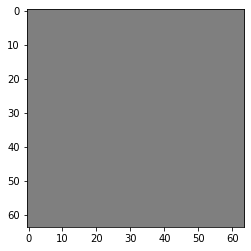

In [10]:
generator = make_generator_model((100,))

noise = np.random.normal(0, 1, 100)
label = 1

generated_image = generator.predict( [np.array([noise]), np.array([label])] )[0]
plt.imshow(unnormalize_img(generated_image), )

In [11]:
def make_discriminator_model():
    input_layer = Input((64, 64, 3))
    x = GaussianNoise(1)(input_layer)
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(input_layer)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    
    x = Flatten()(x)
    x = Dense(200)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    valid = Dense(1, activation='sigmoid')(x)
    label = Dense(10, activation='softmax')(x)
    
    return Model(input_layer, [valid, label])

In [12]:
discriminator = make_discriminator_model()
discriminator.summary()
valid, label = discriminator.predict(np.array([generated_image]))
print(valid)
print(label)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_5[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_10 (LeakyReLU)      (None, 32, 32, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 32, 32, 64)   0           leaky_re_lu_10[0][0]             
____________________________________________________________________________________________

In [13]:
cross_entropy = BinaryCrossentropy(from_logits=False)

def discriminator_valid_loss(real_output, fake_output, flip):
    
    if flip:
        fake_labels = tf.random.uniform(fake_output.shape, minval=0.9, maxval=1.0)
        real_labels = tf.random.uniform(real_output.shape, minval=0.0, maxval=0.1)
    else:
        real_labels = tf.random.uniform(real_output.shape, minval=0.9, maxval=1.0)
        fake_labels = tf.random.uniform(fake_output.shape, minval=0.0, maxval=0.1)

        
    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss, real_loss, fake_loss

In [14]:
sparse_cce = SparseCategoricalCrossentropy(from_logits=False)
cce = CategoricalCrossentropy(from_logits=False)

'''
real_classes, fake_classes: List of class ints (0-200)
real_output, fake_output: List of softmax vectors
'''
def discriminator_class_loss_real(real_output, real_classes):
    return sparse_cce(real_classes, real_output) 

def discriminator_class_loss_fake(fake_output, fake_classes):
    return sparse_cce(fake_classes, fake_output)

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [31]:
@tf.function
def train_step(images, labels, flip, warmup):
    noise = tf.random.truncated_normal([32, 100])
    sampled_labels = tf.cast(tf.random.uniform([32, 1], minval=0, maxval=10, dtype='int32'), 'float32')
#     sampled_labels += tf.random.truncated_normal(sampled_labels.shape, mean=0.0, stddev=0.05)
    labels = tf.reshape(labels, (labels.shape[0], 1))
#     labels += tf.random.truncated_normal(sampled_labels.shape, mean=0.0, stddev=0.05)
    
    
    gen_losses = []
    disc_losses = []
    disc_real_losses = []
    disc_fake_losses = []
    disc_class_real_losses = []
    disc_class_fake_losses = []

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, sampled_labels], training=True)
        
        real_output, real_label_output = discriminator(images, training=True)
        fake_output, fake_label_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss, disc_real_loss, disc_fake_loss = discriminator_valid_loss(real_output, fake_output, flip)
        disc_class_real_loss = discriminator_class_loss_real(real_label_output, labels)
        disc_class_fake_loss = discriminator_class_loss_fake(fake_label_output, sampled_labels)
        disc_loss += ((2.0 - warmup) * disc_class_real_loss + warmup * disc_class_fake_loss)
        
        gen_losses.append(K.mean(gen_loss))
        disc_losses.append(K.mean(disc_loss))
        disc_real_losses.append(K.mean(disc_real_loss))
        disc_fake_losses.append(K.mean(disc_fake_loss))
        disc_class_real_losses.append(K.mean(disc_class_real_loss))
        disc_class_fake_losses.append(K.mean(disc_class_fake_loss))
    
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_losses, disc_losses, disc_real_losses, disc_fake_losses, disc_class_real_losses, disc_class_fake_losses)

In [32]:
def train(train_imgs, train_labels, epochs, warmup):
    gen_loss_all = []
    disc_loss_all = []
    disc_loss_real_all = []
    disc_loss_fake_all = []
    disc_class_loss_real_all = []
    disc_class_loss_fake_all = []
    warmup_step = 1./1000.
    
    num_samples = len(train_imgs)
    batch_counter = 0
    
    for epoch in range(epochs):
        start = time.time()
        
        gen_loss_epoch = [1, 0]
        disc_loss_epoch = [1, 0]
        disc_loss_real_epoch = [1, 0]
        disc_loss_fake_epoch = [1, 0]
        disc_class_loss_real_epoch = [1, 0]
        disc_class_loss_fake_epoch = [1, 0]
        
        seed = np.random.randint(0, 10000)
        np.random.seed(seed)
        np.random.shuffle(train_imgs)
        np.random.seed(seed)
        np.random.shuffle(train_labels)
        
        for idx, i in enumerate(range(0, num_samples - 32, 32)):
            
            gen_loss_batch, disc_loss_batch, disc_loss_real_batch, disc_loss_fake_batch, disc_class_loss_real_batch, disc_class_loss_fake_batch = train_step(train_imgs[i:(i+32)], train_labels[i:(i+32)], batch_counter % 20 == 0, tf.constant(warmup, dtype='float32'))

            gen_loss_epoch[0] += 1
            disc_loss_epoch[0] += 1
            disc_loss_real_epoch[0] += 1
            disc_loss_fake_epoch[0] += 1
            disc_class_loss_real_epoch[0] += 1
            disc_class_loss_fake_epoch[0] += 1
            gen_loss_epoch[1] += np.mean(gen_loss_batch)
            disc_loss_epoch[1] += np.mean(disc_loss_batch)
            disc_loss_real_epoch[1] += np.mean(disc_loss_real_batch)
            disc_loss_fake_epoch[1] += np.mean(disc_loss_fake_batch)
            disc_class_loss_real_epoch[1] += np.mean(disc_class_loss_real_batch)
            disc_class_loss_fake_epoch[1] += np.mean(disc_class_loss_fake_batch)
            
            batch_counter += 1
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print(f'Gen loss: {gen_loss_epoch[1]/gen_loss_epoch[0]}, Disc loss: {disc_loss_epoch[1]/disc_loss_epoch[0]}, Disc valid real loss: {disc_loss_real_epoch[1]/disc_loss_real_epoch[0]}, Disc valid fake loss: {disc_loss_fake_epoch[1]/disc_loss_fake_epoch[0]}, Disc class real loss: {disc_class_loss_real_epoch[1]/disc_class_loss_real_epoch[0]}, Disc class fake loss: {disc_class_loss_fake_epoch[1]/disc_class_loss_fake_epoch[0]}')
        
        gen_loss_all.append(gen_loss_epoch[1]/gen_loss_epoch[0])
        disc_loss_all.append(disc_loss_epoch[1]/disc_loss_epoch[0])
        disc_loss_real_all.append(disc_loss_real_epoch[1]/disc_loss_real_epoch[0])
        disc_loss_fake_all.append(disc_loss_fake_epoch[1]/disc_loss_fake_epoch[0])
        disc_class_loss_real_all.append(disc_class_loss_real_epoch[1]/disc_class_loss_real_epoch[0])
        disc_class_loss_fake_all.append(disc_class_loss_fake_epoch[1]/disc_class_loss_fake_epoch[0])
        
        if warmup < 1:
            warmup += warmup_step
    
    return (gen_loss_all, disc_loss_all, disc_loss_real_all, disc_loss_fake_all, disc_class_loss_real_all, disc_class_loss_fake_all, warmup)
    


In [33]:
def long_train(starting_checkpoint=0, num_checkpoints=0, checkpoint_interval=0, g_hist=None, d_hist=None, d_real_hist=None, d_fake_hist=None, d_class_real_hist=None, d_class_fake_hist=None, noise=None, label=None, save_files=False, warmup=0.):
    
#     if noise is None:
#         noise = np.random.normal(0, 1, 100)

    if g_hist is None:
        g_hist = []
    
    if d_hist is None:
        d_hist = []
        
    if d_real_hist is None:
        d_real_hist = []
    
    if d_fake_hist is None:
        d_fake_hist = []
        
    if d_class_real_hist is None:
        d_class_real_hist = []
        
    if d_class_fake_hist is None:
        d_class_fake_hist = []

    for i in range(starting_checkpoint, starting_checkpoint + num_checkpoints):
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        print('')
        print(f'Starting checkpoint {i}')
        print('')
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
        gen_temp, disc_temp, disc_real_temp, disc_fake_temp, disc_class_real_temp, disc_class_fake_temp, warmup = train(train_imgs, train_classes, checkpoint_interval, warmup)
        g_hist += gen_temp
        d_hist += disc_temp
        d_real_hist += disc_real_temp
        d_fake_hist += disc_fake_temp
        d_class_real_hist += disc_class_real_temp
        d_class_fake_hist += disc_class_fake_temp
        generated_image = generator.predict( [np.array([noise]), np.array([label])])[0]
        plt.imshow(unnormalize_img(generated_image))
        if save_files:
            plt.savefig('./results/prog-imgs/animal-gan-conditional-10-samples-bigger/' + str((i+1)*checkpoint_interval) + '.png')
        plt.show()
        if save_files:
            generator.save_weights('./results/weights/animal-gan-conditional-10-samples-bigger/gen_weights_conditional_10_samples_bigger_' + str((i+1)*checkpoint_interval) + '.h5')
            discriminator.save_weights('./results/weights/animal-gan-conditional-10-samples-bigger/disc_weights_conditional_10_samples_bigger_' + str((i+1)*checkpoint_interval) + '.h5')
    
    return starting_checkpoint + num_checkpoints, totalepochs, warmup

In [29]:
discriminator = make_discriminator_model()
generator = make_generator_model((100,))
generator_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_optimizer = Adam(2e-4, beta_1=0.5)

In [30]:
# To get passed into training function and get modified
# Run cell when starting from scratch
gen_loss_hist = []
disc_loss_hist = []
disc_loss_real_hist = []
disc_loss_fake_hist = []
disc_class_loss_real_hist = []
disc_class_loss_fake_hist = []
noise100 = np.random.normal(0, 1, 100)
label = 5
next_starting_checkpoint = 0
totalepochs = 0
warmup = 0. # NO WARMUP

5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 0

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Time for epoch 1 is 22.149169206619263 sec
Gen loss: 1.6718981542262765, Disc loss: 4.727819437204405, Disc valid real loss: 0.5604930159657501, Disc valid fake loss: 0.6713322951176832, Disc class real loss: 1.7479970656162085, Disc class fake loss: 3.133742884147999
Time for epoch 2 is 18.536831617355347 sec
Gen loss: 1.5362677717287645, Disc loss: 3.83322668214177, Disc valid real los

Time for epoch 29 is 19.345504999160767 sec
Gen loss: 0.9094871826643167, Disc loss: 1.6255758647308793, Disc valid real loss: 0.64724190827719, Disc valid fake loss: 0.6241712152611377, Disc class real loss: 0.08396363139239162, Disc class fake loss: 6.735230828440467
Time for epoch 30 is 19.259270668029785 sec
Gen loss: 0.8902512341737747, Disc loss: 1.6488823738209037, Disc valid real loss: 0.6595125465199004, Disc valid fake loss: 0.6226961553789848, Disc class real loss: 0.08873717224788527, Disc class fake loss: 6.612852357154669
Time for epoch 31 is 19.248863697052002 sec
Gen loss: 0.9346578776143318, Disc loss: 1.6280096000017121, Disc valid real loss: 0.6393494878050893, Disc valid fake loss: 0.6170024364147075, Disc class real loss: 0.09003553558465872, Disc class fake loss: 6.47625579390415
Time for epoch 32 is 19.252558946609497 sec
Gen loss: 0.9264029292173164, Disc loss: 1.6252357668654864, Disc valid real loss: 0.6504129048350246, Disc valid fake loss: 0.6132352433578913

Time for epoch 60 is 19.685112237930298 sec
Gen loss: 0.9538936351620874, Disc loss: 1.6254961476769558, Disc valid real loss: 0.629778939450896, Disc valid fake loss: 0.5839708156363909, Disc class real loss: 0.06537522942499192, Disc class fake loss: 4.828018372835115
Time for epoch 61 is 19.46996569633484 sec
Gen loss: 0.956881832591323, Disc loss: 1.6322992437107617, Disc valid real loss: 0.62346077987621, Disc valid fake loss: 0.5864147226824317, Disc class real loss: 0.0684273887458149, Disc class fake loss: 4.827910201494084
Time for epoch 62 is 19.47347640991211 sec
Gen loss: 1.0006225511085156, Disc loss: 1.6312530324902645, Disc valid real loss: 0.6298803155158841, Disc valid fake loss: 0.5747512821541276, Disc class real loss: 0.06974088558710592, Disc class fake loss: 4.7769484159558315
Time for epoch 63 is 19.489162921905518 sec
Gen loss: 1.0025627238805903, Disc loss: 1.6219173489614975, Disc valid real loss: 0.6206671106953954, Disc valid fake loss: 0.5762767814273058, D

Time for epoch 91 is 19.52991795539856 sec
Gen loss: 0.9699922619863998, Disc loss: 1.6565119270668474, Disc valid real loss: 0.6260852259258891, Disc valid fake loss: 0.5903946048645086, Disc class real loss: 0.06686255082401425, Disc class fake loss: 3.4702734600665956
Time for epoch 92 is 19.56888747215271 sec
Gen loss: 0.9876847374577855, Disc loss: 1.6224320752676142, Disc valid real loss: 0.6245922551945199, Disc valid fake loss: 0.5803013047160104, Disc class real loss: 0.05890699491164712, Disc class fake loss: 3.352583057658617
Time for epoch 93 is 19.643418312072754 sec
Gen loss: 0.9813818806825683, Disc loss: 1.6465866094411805, Disc valid real loss: 0.6322480935690015, Disc valid fake loss: 0.5943692524072736, Disc class real loss: 0.05920552795882835, Disc class fake loss: 3.33701219461685
Time for epoch 94 is 19.750104904174805 sec
Gen loss: 0.9623598851436792, Disc loss: 1.6467202021632084, Disc valid real loss: 0.6309506392409635, Disc valid fake loss: 0.588216741417729

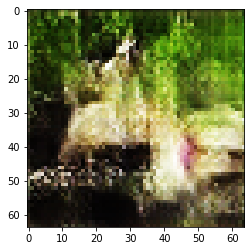

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 1

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 19.4936683177948 sec
Gen loss: 0.9675538401271022, Disc loss: 1.6513080950393233, Disc valid real loss: 0.6358425719446914, Disc valid fake loss: 0.5949009818046592, Disc class real loss: 0.0614230754828557, Disc class fake loss: 3.038606884867646
Time for epoch 2 is 19.708436727523804 sec
Gen loss: 0.9842122006554936, Disc loss: 1.638512289108232, Disc valid real loss: 0.6282517693417017, Disc valid fake loss: 0.5869625803343085, Disc class real loss: 0.06418494924599695, Disc class fake loss: 2.9842644375424054
Time for epoch 3 is 19.538433074951172 sec
Gen loss: 0.9584754649982896, Disc loss: 1.639036157103472, Disc valid real loss: 0.6254885512035947, Disc valid fake loss: 0.5898570728509925, Disc class real loss: 0.06682671617911479, Disc class fake loss: 2.9103278129599817
Time for epoch 4 is 19.575641870498657 sec
Gen loss: 0.9761212132004804, D

Time for epoch 31 is 19.603245973587036 sec
Gen loss: 0.9813648510810941, Disc loss: 1.614973490321359, Disc valid real loss: 0.635259349678838, Disc valid fake loss: 0.588506159740825, Disc class real loss: 0.05942766686771498, Disc class fake loss: 2.154448102379954
Time for epoch 32 is 19.604456901550293 sec
Gen loss: 0.9728891055944354, Disc loss: 1.613884302072747, Disc valid real loss: 0.6303725197564723, Disc valid fake loss: 0.5866601798076962, Disc class real loss: 0.06163832305952213, Disc class fake loss: 2.149996809488119
Time for epoch 33 is 19.598012924194336 sec
Gen loss: 0.9553465063488761, Disc loss: 1.6111308606558068, Disc valid real loss: 0.6256440583356592, Disc valid fake loss: 0.5983132830885953, Disc class real loss: 0.05862647629624536, Disc class fake loss: 2.103479286959005
Time for epoch 34 is 19.635823965072632 sec
Gen loss: 0.9807959798463556, Disc loss: 1.6057761651138927, Disc valid real loss: 0.632679640900257, Disc valid fake loss: 0.5874208026500636, 

Time for epoch 62 is 19.578586101531982 sec
Gen loss: 0.999973036522089, Disc loss: 1.5510350562805353, Disc valid real loss: 0.6215837218387182, Disc valid fake loss: 0.5846076794835025, Disc class real loss: 0.05459918427216106, Disc class fake loss: 1.518234534319057
Time for epoch 63 is 19.5721378326416 sec
Gen loss: 0.9782969521921735, Disc loss: 1.5476927577063095, Disc valid real loss: 0.6265348722768385, Disc valid fake loss: 0.5868154836948528, Disc class real loss: 0.05651210265120405, Disc class fake loss: 1.422673767389253
Time for epoch 64 is 19.579923152923584 sec
Gen loss: 0.9909454986106517, Disc loss: 1.5524453992067382, Disc valid real loss: 0.6197800067968147, Disc valid fake loss: 0.5838165203499239, Disc class real loss: 0.05662174196643105, Disc class fake loss: 1.502053515162579
Time for epoch 65 is 19.617803812026978 sec
Gen loss: 0.9817018099995547, Disc loss: 1.5415179868077122, Disc valid real loss: 0.6137418424667314, Disc valid fake loss: 0.5862442759233851

Time for epoch 93 is 19.642870903015137 sec
Gen loss: 0.974960348287294, Disc loss: 1.5126918339452078, Disc valid real loss: 0.6298357187662014, Disc valid fake loss: 0.5979263179524, Disc class real loss: 0.04812161665041606, Disc class fake loss: 1.0308641531439715
Time for epoch 94 is 19.597790241241455 sec
Gen loss: 0.9592201075581617, Disc loss: 1.504776732866154, Disc valid real loss: 0.6281136813205342, Disc valid fake loss: 0.5969979782090631, Disc class real loss: 0.05084630399184345, Disc class fake loss: 0.9729834353161413
Time for epoch 95 is 19.675498485565186 sec
Gen loss: 0.966836977490159, Disc loss: 1.5161451877549637, Disc valid real loss: 0.6282466492334078, Disc valid fake loss: 0.5984833716999652, Disc class real loss: 0.052283431511632235, Disc class fake loss: 1.0051097109220748
Time for epoch 96 is 19.65086603164673 sec
Gen loss: 0.9689177468765614, Disc loss: 1.5182863508546076, Disc valid real loss: 0.6228445000773253, Disc valid fake loss: 0.5978006647769795

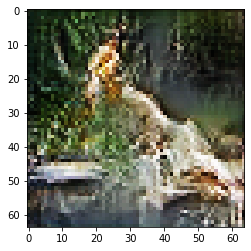

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 2

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 19.68515682220459 sec
Gen loss: 0.9669409106637157, Disc loss: 1.4890964273796525, Disc valid real loss: 0.63408049923736, Disc valid fake loss: 0.6004674353225287, Disc class real loss: 0.042452338345208056, Disc class fake loss: 0.8906714055080747
Time for epoch 2 is 19.638003826141357 sec
Gen loss: 0.9667310943437177, Disc loss: 1.4676771822363832, Disc valid real loss: 0.6286274019715398, Disc valid fake loss: 0.5973440329002779, Disc class real loss: 0.04034028493333608, Disc class fake loss: 0.8414605304945347
Time for epoch 3 is 19.659083366394043 sec
Gen loss: 0.97417690137098, Disc loss: 1.490076173876607, Disc valid real loss: 0.6285025557113249, Disc valid fake loss: 0.5915077884876451, Disc class real loss: 0.0527090061927041, Disc class fake loss: 0.8677971714804339
Time for epoch 4 is 19.669832706451416 sec
Gen loss: 0.9697212531816127, D

Time for epoch 31 is 19.653074502944946 sec
Gen loss: 0.9562664385451827, Disc loss: 1.4584993817085443, Disc valid real loss: 0.6291096660979959, Disc valid fake loss: 0.6065486967563629, Disc class real loss: 0.04471511527663097, Disc class fake loss: 0.6247620098292828
Time for epoch 32 is 19.697477102279663 sec
Gen loss: 0.9539512700812761, Disc loss: 1.4410272192123323, Disc valid real loss: 0.6327859762796136, Disc valid fake loss: 0.5966261285682057, Disc class real loss: 0.042843436397243896, Disc class fake loss: 0.5879872991855062
Time for epoch 33 is 19.678273916244507 sec
Gen loss: 0.9385867486166399, Disc loss: 1.4864761351152909, Disc valid real loss: 0.6339955925941467, Disc valid fake loss: 0.6087056660028392, Disc class real loss: 0.05450094605086718, Disc class fake loss: 0.6354190015862154
Time for epoch 34 is 19.666606187820435 sec
Gen loss: 0.948022432798563, Disc loss: 1.4479809015296226, Disc valid real loss: 0.6274797117640806, Disc valid fake loss: 0.6046495910

Time for epoch 62 is 19.713483095169067 sec
Gen loss: 0.9364643055339192, Disc loss: 1.415916147620179, Disc valid real loss: 0.6314747553578642, Disc valid fake loss: 0.6091773603544679, Disc class real loss: 0.04031366342272566, Disc class fake loss: 0.40290640736388605
Time for epoch 63 is 19.660658836364746 sec
Gen loss: 0.9410109693227813, Disc loss: 1.4202710424744807, Disc valid real loss: 0.6237676446867544, Disc valid fake loss: 0.6090136842672215, Disc class real loss: 0.04073251259302027, Disc class fake loss: 0.4454068988994804
Time for epoch 64 is 19.66826558113098 sec
Gen loss: 0.933163961352304, Disc loss: 1.4117893271668012, Disc valid real loss: 0.6268814748456312, Disc valid fake loss: 0.6091462099968001, Disc class real loss: 0.041676513382997146, Disc class fake loss: 0.3930400565786417
Time for epoch 65 is 19.66872477531433 sec
Gen loss: 0.938192819093549, Disc loss: 1.4207257469033086, Disc valid real loss: 0.6296992003917694, Disc valid fake loss: 0.6109120053953

Time for epoch 93 is 19.687055349349976 sec
Gen loss: 0.9337449753007223, Disc loss: 1.3796668697235197, Disc valid real loss: 0.6351879880178807, Disc valid fake loss: 0.6103891907043235, Disc class real loss: 0.034028939783659784, Disc class fake loss: 0.2601652587060059
Time for epoch 94 is 19.685056686401367 sec
Gen loss: 0.9442169856886531, Disc loss: 1.3834996992765471, Disc valid real loss: 0.6332981732002524, Disc valid fake loss: 0.6063521663809932, Disc class real loss: 0.03855941372958748, Disc class fake loss: 0.26630865554000405
Time for epoch 95 is 19.6572482585907 sec
Gen loss: 0.9364373812148737, Disc loss: 1.3840320796467538, Disc valid real loss: 0.6326031440565753, Disc valid fake loss: 0.60930624136398, Disc class real loss: 0.03347112883581525, Disc class fake loss: 0.2891869053547812
Time for epoch 96 is 19.662169218063354 sec
Gen loss: 0.9439726853093435, Disc loss: 1.3942614523477332, Disc valid real loss: 0.6269009875696759, Disc valid fake loss: 0.609037462188

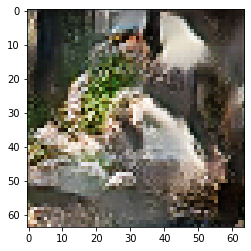

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 3

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 19.673251390457153 sec
Gen loss: 0.9304025031106417, Disc loss: 1.3903098182622777, Disc valid real loss: 0.6355179288359576, Disc valid fake loss: 0.6148382520606351, Disc class real loss: 0.037633940235706216, Disc class fake loss: 0.2532531125579289
Time for epoch 2 is 19.669968605041504 sec
Gen loss: 0.9420654590046683, Disc loss: 1.382389912078547, Disc valid real loss: 0.6321236290210901, Disc valid fake loss: 0.6149030119873756, Disc class real loss: 0.034312693418415134, Disc class fake loss: 0.2560332394963087
Time for epoch 3 is 19.68118691444397 sec
Gen loss: 0.940743011444114, Disc loss: 1.3813862038213154, Disc valid real loss: 0.6317562282431958, Disc valid fake loss: 0.6054874991261682, Disc class real loss: 0.03585172921681755, Disc class fake loss: 0.2757160422002334
Time for epoch 4 is 19.668671369552612 sec
Gen loss: 0.93070670789064

Time for epoch 31 is 19.677637338638306 sec
Gen loss: 0.9464351628408876, Disc loss: 1.3506264506384384, Disc valid real loss: 0.6333282328275747, Disc valid fake loss: 0.6041621936615124, Disc class real loss: 0.02685185166173628, Disc class fake loss: 0.20694980267868485
Time for epoch 32 is 19.66636037826538 sec
Gen loss: 0.9424359649419785, Disc loss: 1.3677689758844154, Disc valid real loss: 0.6277787536382675, Disc valid fake loss: 0.6089576021876446, Disc class real loss: 0.034321803124966695, Disc class fake loss: 0.22280823858454823
Time for epoch 33 is 19.682369470596313 sec
Gen loss: 0.9531209319829941, Disc loss: 1.386801075103671, Disc valid real loss: 0.6245280686159467, Disc valid fake loss: 0.6159239348977111, Disc class real loss: 0.03670408493332595, Disc class fake loss: 0.25640562347807855
Time for epoch 34 is 19.664942264556885 sec
Gen loss: 0.9316984487827434, Disc loss: 1.3732205767964207, Disc valid real loss: 0.6327985031313674, Disc valid fake loss: 0.60852199

Time for epoch 61 is 19.68352723121643 sec
Gen loss: 0.949494673415672, Disc loss: 1.3638523567554564, Disc valid real loss: 0.6278493270971054, Disc valid fake loss: 0.6125472737259643, Disc class real loss: 0.03360436380459104, Disc class fake loss: 0.1898460984852728
Time for epoch 62 is 19.669896125793457 sec
Gen loss: 0.9422142034353211, Disc loss: 1.348511166350786, Disc valid real loss: 0.6288727767938791, Disc valid fake loss: 0.609721475562384, Disc class real loss: 0.029512944724512297, Disc class fake loss: 0.1704853172197418
Time for epoch 63 is 19.65897488594055 sec
Gen loss: 0.9377178341843361, Disc loss: 1.3502747575904048, Disc valid real loss: 0.6294318957384243, Disc valid fake loss: 0.606890908160875, Disc class real loss: 0.03321407486340789, Disc class fake loss: 0.16449530581607982
Time for epoch 64 is 19.684052228927612 sec
Gen loss: 0.9400572149559508, Disc loss: 1.3536883356959322, Disc valid real loss: 0.6337599054325459, Disc valid fake loss: 0.61311660395112

Time for epoch 92 is 19.71901512145996 sec
Gen loss: 0.9757747078357741, Disc loss: 1.3273677063542744, Disc valid real loss: 0.6242324701228807, Disc valid fake loss: 0.5961561154487521, Disc class real loss: 0.030453239446593894, Disc class fake loss: 0.14828607733198984
Time for epoch 93 is 19.732285499572754 sec
Gen loss: 0.955921255225359, Disc loss: 1.3469179508297942, Disc valid real loss: 0.629326757823312, Disc valid fake loss: 0.6090888547342878, Disc class real loss: 0.029501482035283157, Disc class fake loss: 0.1557754020823902
Time for epoch 94 is 19.71475648880005 sec
Gen loss: 0.9591720980960269, Disc loss: 1.322279623774595, Disc valid real loss: 0.6253940821733586, Disc valid fake loss: 0.6026353718236436, Disc class real loss: 0.022647973012279308, Disc class fake loss: 0.14721344879098766
Time for epoch 95 is 19.71506929397583 sec
Gen loss: 0.9650294756473496, Disc loss: 1.3319847251093664, Disc valid real loss: 0.6208987785286681, Disc valid fake loss: 0.60768688972

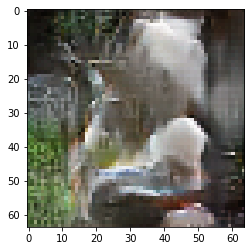

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 4

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 19.73578190803528 sec
Gen loss: 0.9550219254438267, Disc loss: 1.3431430521399477, Disc valid real loss: 0.6287235264168229, Disc valid fake loss: 0.6106571756130041, Disc class real loss: 0.029651029169631225, Disc class fake loss: 0.1408017512849467
Time for epoch 2 is 19.752182960510254 sec
Gen loss: 0.947622575385626, Disc loss: 1.351852253425953, Disc valid real loss: 0.6274004502351894, Disc valid fake loss: 0.6104306893986325, Disc class real loss: 0.03618477289976084, Disc class fake loss: 0.14005400882329966
Time for epoch 3 is 19.698087215423584 sec
Gen loss: 0.9568379008492758, Disc loss: 1.3410401711630267, Disc valid real loss: 0.6296127197700877, Disc valid fake loss: 0.5994833115228387, Disc class real loss: 0.029236107533760394, Disc class fake loss: 0.16225084344596538
Time for epoch 4 is 19.706357955932617 sec
Gen loss: 0.950766936637

Time for epoch 31 is 19.741461753845215 sec
Gen loss: 0.9810981026222539, Disc loss: 1.3213395968426105, Disc valid real loss: 0.6247443721391434, Disc valid fake loss: 0.597289165611877, Disc class real loss: 0.030695963178385324, Disc class fake loss: 0.11886836012820633
Time for epoch 32 is 19.73239517211914 sec
Gen loss: 0.9722350090742111, Disc loss: 1.3157968403295028, Disc valid real loss: 0.6217151441892912, Disc valid fake loss: 0.5984880497982336, Disc class real loss: 0.027537093358977326, Disc class fake loss: 0.12154976677384395
Time for epoch 33 is 19.743772745132446 sec
Gen loss: 0.9838880092598671, Disc loss: 1.3284122992393583, Disc valid real loss: 0.6260883203426073, Disc valid fake loss: 0.5997223225097323, Disc class real loss: 0.02811433395711288, Disc class fake loss: 0.1354592008188605
Time for epoch 34 is 19.710399627685547 sec
Gen loss: 0.9721278118532758, Disc loss: 1.3061172892880994, Disc valid real loss: 0.6167559528420138, Disc valid fake loss: 0.60105092

Time for epoch 62 is 19.705772638320923 sec
Gen loss: 0.987328649260277, Disc loss: 1.3178874919580859, Disc valid real loss: 0.6141481144830238, Disc valid fake loss: 0.5981133628723233, Disc class real loss: 0.03378676590871819, Disc class fake loss: 0.11633011607079614
Time for epoch 63 is 19.74581027030945 sec
Gen loss: 0.9936630809029867, Disc loss: 1.3318464062934698, Disc valid real loss: 0.6216418663429659, Disc valid fake loss: 0.5982236817132595, Disc class real loss: 0.03285127308083966, Disc class fake loss: 0.1330207848317683
Time for epoch 64 is 19.730749130249023 sec
Gen loss: 0.9803010214899861, Disc loss: 1.3182007462479348, Disc valid real loss: 0.6248432141403819, Disc valid fake loss: 0.6005659016758896, Disc class real loss: 0.02801716757101023, Disc class fake loss: 0.10740657188174271
Time for epoch 65 is 19.70900249481201 sec
Gen loss: 0.9932725585477297, Disc loss: 1.2937323769857718, Disc valid real loss: 0.6132748915359031, Disc valid fake loss: 0.59177763448

Time for epoch 93 is 19.670082092285156 sec
Gen loss: 1.0102462009635083, Disc loss: 1.2979929246181665, Disc valid real loss: 0.6142957331829293, Disc valid fake loss: 0.5868239967628966, Disc class real loss: 0.027088703713880658, Disc class fake loss: 0.1138687729588466
Time for epoch 94 is 19.709108352661133 sec
Gen loss: 1.0166875848243402, Disc loss: 1.2901297544324122, Disc valid real loss: 0.6136625651703325, Disc valid fake loss: 0.5881659847705863, Disc class real loss: 0.023651248609429215, Disc class fake loss: 0.10681291667373613
Time for epoch 95 is 19.67206859588623 sec
Gen loss: 1.0082554058280102, Disc loss: 1.3062518301398256, Disc valid real loss: 0.6115077207254809, Disc valid fake loss: 0.5896786647134049, Disc class real loss: 0.03688666149258118, Disc class fake loss: 0.10023105679808163
Time for epoch 96 is 19.662564992904663 sec
Gen loss: 1.029285395214724, Disc loss: 1.2967240054940068, Disc valid real loss: 0.6079263477477916, Disc valid fake loss: 0.57861628

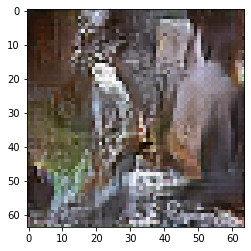

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 5

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 19.682252168655396 sec
Gen loss: 1.0236332440792129, Disc loss: 1.2976639603459559, Disc valid real loss: 0.6108323297528333, Disc valid fake loss: 0.5872457677195239, Disc class real loss: 0.02816080575897548, Disc class fake loss: 0.11468930280602234
Time for epoch 2 is 19.667539596557617 sec
Gen loss: 1.0120060346847357, Disc loss: 1.309219948081083, Disc valid real loss: 0.609887263282787, Disc valid fake loss: 0.5983433740776639, Disc class real loss: 0.029394078562692685, Disc class fake loss: 0.11362791663512241
Time for epoch 3 is 19.661187648773193 sec
Gen loss: 1.0087129033582156, Disc loss: 1.3118307403353757, Disc valid real loss: 0.6192867845989937, Disc valid fake loss: 0.5926716871732889, Disc class real loss: 0.02575062719873575, Disc class fake loss: 0.12210723731228892
Time for epoch 4 is 19.671621561050415 sec
Gen loss: 1.02078678164

Time for epoch 31 is 19.691553354263306 sec
Gen loss: 1.024757832288742, Disc loss: 1.3023255259491677, Disc valid real loss: 0.6207852285615233, Disc valid fake loss: 0.5883041590798733, Disc class real loss: 0.02830870952404735, Disc class fake loss: 0.09740062499085345
Time for epoch 32 is 19.682923793792725 sec
Gen loss: 1.0296224771543991, Disc loss: 1.284132143785787, Disc valid real loss: 0.6067070243663566, Disc valid fake loss: 0.5865056724395863, Disc class real loss: 0.028362694772895762, Disc class fake loss: 0.0927582844911782
Time for epoch 33 is 19.65083909034729 sec
Gen loss: 1.0238701174425524, Disc loss: 1.30166106896345, Disc valid real loss: 0.6145212379998939, Disc valid fake loss: 0.594032515966615, Disc class real loss: 0.026549713613095202, Disc class fake loss: 0.10175251965289177
Time for epoch 34 is 19.65939712524414 sec
Gen loss: 1.0241311535585758, Disc loss: 1.289191715246023, Disc valid real loss: 0.6071049882922062, Disc valid fake loss: 0.58513540410718

Time for epoch 61 is 19.715691566467285 sec
Gen loss: 1.0405102098403975, Disc loss: 1.2919171979261, Disc valid real loss: 0.6162333050092985, Disc valid fake loss: 0.5868662535104641, Disc class real loss: 0.025843153032732262, Disc class fake loss: 0.09214909419359513
Time for epoch 62 is 19.69036602973938 sec
Gen loss: 1.035375554894292, Disc loss: 1.2835958721332772, Disc valid real loss: 0.6043657185726388, Disc valid fake loss: 0.584938210283601, Disc class real loss: 0.03166995380634881, Disc class fake loss: 0.08684292518168953
Time for epoch 63 is 19.64521288871765 sec
Gen loss: 1.0498675353998361, Disc loss: 1.2690903128579605, Disc valid real loss: 0.6020481328285018, Disc valid fake loss: 0.5798957841687424, Disc class real loss: 0.021381432526479414, Disc class fake loss: 0.10035569501768657
Time for epoch 64 is 19.678987979888916 sec
Gen loss: 1.0475592838470327, Disc loss: 1.2963119717531426, Disc valid real loss: 0.6039674730841503, Disc valid fake loss: 0.584783130780

Time for epoch 91 is 19.70572280883789 sec
Gen loss: 1.0573668168034664, Disc loss: 1.281925801620927, Disc valid real loss: 0.6010438487973324, Disc valid fake loss: 0.581487387418747, Disc class real loss: 0.03413623981176115, Disc class fake loss: 0.08688554187375662
Time for epoch 92 is 19.672029972076416 sec
Gen loss: 1.0440140560615894, Disc loss: 1.2742813770161119, Disc valid real loss: 0.6071326500454615, Disc valid fake loss: 0.5789413351652234, Disc class real loss: 0.030859772986332246, Disc class fake loss: 0.07567844854117517
Time for epoch 93 is 19.66204285621643 sec
Gen loss: 1.0501950438632521, Disc loss: 1.276025453972262, Disc valid real loss: 0.6060584159784539, Disc valid fake loss: 0.5866066856786262, Disc class real loss: 0.02835252195555493, Disc class fake loss: 0.07337837059441331
Time for epoch 94 is 19.660829544067383 sec
Gen loss: 1.0477022968752439, Disc loss: 1.283272702333539, Disc valid real loss: 0.6033948022265767, Disc valid fake loss: 0.582182932038

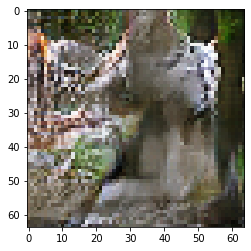

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 6

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 19.526817321777344 sec
Gen loss: 1.0562239362056864, Disc loss: 1.2836915913016298, Disc valid real loss: 0.6069200420102407, Disc valid fake loss: 0.5820019983274992, Disc class real loss: 0.029255843234010214, Disc class fake loss: 0.08968561651154021
Time for epoch 2 is 19.69721269607544 sec
Gen loss: 1.0688769865867704, Disc loss: 1.2623512412226476, Disc valid real loss: 0.5995477498617283, Disc valid fake loss: 0.5773611311302629, Disc class real loss: 0.026973682747010633, Disc class fake loss: 0.0793780088431451
Time for epoch 3 is 19.769548892974854 sec
Gen loss: 1.0632268495337909, Disc loss: 1.2810457352288933, Disc valid real loss: 0.5992933381782022, Disc valid fake loss: 0.582986711589403, Disc class real loss: 0.03327502446581791, Disc class fake loss: 0.0867893660270479
Time for epoch 4 is 19.47209882736206 sec
Gen loss: 1.0611390093731

Time for epoch 31 is 19.63877010345459 sec
Gen loss: 1.0687452984410664, Disc loss: 1.2578423601943394, Disc valid real loss: 0.600943707102953, Disc valid fake loss: 0.5794232981496079, Disc class real loss: 0.026547551463980114, Disc class fake loss: 0.06524637147146656
Time for epoch 32 is 19.640731811523438 sec
Gen loss: 1.0785194836383643, Disc loss: 1.2718668767186099, Disc valid real loss: 0.5947302564285523, Disc valid fake loss: 0.5779518426157707, Disc class real loss: 0.029890783592299856, Disc class fake loss: 0.09233644847581461
Time for epoch 33 is 19.634464979171753 sec
Gen loss: 1.0698818446591842, Disc loss: 1.2651765183653942, Disc valid real loss: 0.6015477864894756, Disc valid fake loss: 0.5797914557678755, Disc class real loss: 0.025482101610133784, Disc class fake loss: 0.07749645323336915
Time for epoch 34 is 19.675942182540894 sec
Gen loss: 1.0849548647570055, Disc loss: 1.245177156356878, Disc valid real loss: 0.5886047037188397, Disc valid fake loss: 0.5721741

Time for epoch 61 is 19.641758680343628 sec
Gen loss: 1.1115577945182489, Disc loss: 1.242797288783761, Disc valid real loss: 0.5916701213911523, Disc valid fake loss: 0.559942937867586, Disc class real loss: 0.028227146816450756, Disc class fake loss: 0.08084826067559249
Time for epoch 62 is 19.64415669441223 sec
Gen loss: 1.1043476389591085, Disc loss: 1.256537136643432, Disc valid real loss: 0.5939456735586011, Disc valid fake loss: 0.5697464566937712, Disc class real loss: 0.024501719798515065, Disc class fake loss: 0.09082782411471356
Time for epoch 63 is 19.61726212501526 sec
Gen loss: 1.0998288517774537, Disc loss: 1.2535543816034185, Disc valid real loss: 0.5904670856719794, Disc valid fake loss: 0.5679386363819589, Disc class real loss: 0.03170887712922406, Disc class fake loss: 0.07964075341120871
Time for epoch 64 is 19.706952810287476 sec
Gen loss: 1.1016829360363096, Disc loss: 1.2616384258103925, Disc valid real loss: 0.5977306508047636, Disc valid fake loss: 0.5720571480

Time for epoch 91 is 19.63544225692749 sec
Gen loss: 1.1005386162635893, Disc loss: 1.2621300764555154, Disc valid real loss: 0.5989908404475035, Disc valid fake loss: 0.5729755972360455, Disc class real loss: 0.03148622655998076, Disc class fake loss: 0.07089373939041167
Time for epoch 92 is 19.642552375793457 sec
Gen loss: 1.1037540013013885, Disc loss: 1.2372038215398788, Disc valid real loss: 0.5869509537899217, Disc valid fake loss: 0.5695221101821855, Disc class real loss: 0.02416373557453817, Disc class fake loss: 0.07105707352541707
Time for epoch 93 is 19.636635065078735 sec
Gen loss: 1.1180154310409414, Disc loss: 1.2427518866782965, Disc valid real loss: 0.5855634442942087, Disc valid fake loss: 0.5631078715587772, Disc class real loss: 0.03137420647684383, Disc class fake loss: 0.0766518866727237
Time for epoch 94 is 19.639950275421143 sec
Gen loss: 1.118767376555953, Disc loss: 1.237592917542125, Disc valid real loss: 0.5834654469129651, Disc valid fake loss: 0.56686009189

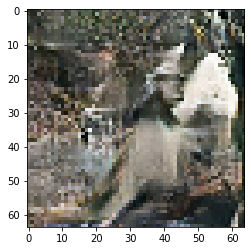

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 7

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 19.61409568786621 sec
Gen loss: 1.118162677731625, Disc loss: 1.234229294020076, Disc valid real loss: 0.5925131521599237, Disc valid fake loss: 0.5632072778981786, Disc class real loss: 0.026279699306457568, Disc class fake loss: 0.06335036223314346
Time for epoch 2 is 19.50434398651123 sec
Gen loss: 1.1092446418695672, Disc loss: 1.2488293467566025, Disc valid real loss: 0.5939912120270174, Disc valid fake loss: 0.571124022783235, Disc class real loss: 0.022860019635921817, Disc class fake loss: 0.07705984140235625
Time for epoch 3 is 19.577037572860718 sec
Gen loss: 1.1077226362256116, Disc loss: 1.2555105329252954, Disc valid real loss: 0.5861174973637558, Disc valid fake loss: 0.5703540148083553, Disc class real loss: 0.03498885625645756, Disc class fake loss: 0.07638672986446858
Time for epoch 4 is 19.59646201133728 sec
Gen loss: 1.12469223280285

Time for epoch 31 is 19.745352029800415 sec
Gen loss: 1.1214596982612166, Disc loss: 1.2440281964318698, Disc valid real loss: 0.597607650209305, Disc valid fake loss: 0.5702213903152665, Disc class real loss: 0.02813043862079212, Disc class fake loss: 0.055443149699110725
Time for epoch 32 is 19.765438556671143 sec
Gen loss: 1.1302576577940653, Disc loss: 1.2241188111000283, Disc valid real loss: 0.5860305884203245, Disc valid fake loss: 0.5541675584607346, Disc class real loss: 0.02463611510646906, Disc class fake loss: 0.07203478959634721
Time for epoch 33 is 19.496719360351562 sec
Gen loss: 1.125935945399972, Disc loss: 1.257668498643609, Disc valid real loss: 0.5937661268683367, Disc valid fake loss: 0.562937656807345, Disc class real loss: 0.03408137714266263, Disc class fake loss: 0.07889279780461356
Time for epoch 34 is 19.81326723098755 sec
Gen loss: 1.11047462356645, Disc loss: 1.2349963642136996, Disc valid real loss: 0.5855892733779064, Disc valid fake loss: 0.5647557265190

Time for epoch 61 is 19.59410262107849 sec
Gen loss: 1.132307551974474, Disc loss: 1.2361378004384596, Disc valid real loss: 0.582614847393923, Disc valid fake loss: 0.5673821079869603, Disc class real loss: 0.030762660483116294, Disc class fake loss: 0.06315150786428793
Time for epoch 62 is 19.63289713859558 sec
Gen loss: 1.143289488761924, Disc loss: 1.2172976642153983, Disc valid real loss: 0.5904712037638177, Disc valid fake loss: 0.5500829088133435, Disc class real loss: 0.025872925227431127, Disc class fake loss: 0.05872141008047376
Time for epoch 63 is 19.604109287261963 sec
Gen loss: 1.13580386375272, Disc loss: 1.2282190191191296, Disc valid real loss: 0.5847094703552335, Disc valid fake loss: 0.557131270683089, Disc class real loss: 0.0326396025447625, Disc class fake loss: 0.06032867052839043
Time for epoch 64 is 19.568554162979126 sec
Gen loss: 1.15151432364486, Disc loss: 1.214447860454404, Disc valid real loss: 0.5794659679712251, Disc valid fake loss: 0.5548927433962045,

Time for epoch 91 is 19.588560104370117 sec
Gen loss: 1.1506059329177059, Disc loss: 1.2322219267140988, Disc valid real loss: 0.5821319281361824, Disc valid fake loss: 0.5617268376572188, Disc class real loss: 0.0283754470133846, Disc class fake loss: 0.06839098403606629
Time for epoch 92 is 19.58815908432007 sec
Gen loss: 1.1509110054304434, Disc loss: 1.2218468203101047, Disc valid real loss: 0.5830980489073798, Disc valid fake loss: 0.5533606559038162, Disc class real loss: 0.031351729064247824, Disc class fake loss: 0.06003018290035936
Time for epoch 93 is 19.633707523345947 sec
Gen loss: 1.1619801909424539, Disc loss: 1.2410489431647367, Disc valid real loss: 0.5888276250902996, Disc valid fake loss: 0.5589914848638136, Disc class real loss: 0.03096033421737703, Disc class fake loss: 0.07049210620074477
Time for epoch 94 is 19.60732340812683 sec
Gen loss: 1.1499492588431337, Disc loss: 1.2208309908245885, Disc valid real loss: 0.5835138914543528, Disc valid fake loss: 0.549504380

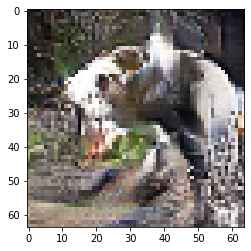

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 8

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 19.58658719062805 sec
Gen loss: 1.1670259701651196, Disc loss: 1.211067956893943, Disc valid real loss: 0.5796292879900267, Disc valid fake loss: 0.5494745737591455, Disc class real loss: 0.028477195467149972, Disc class fake loss: 0.0597393212095106
Time for epoch 2 is 19.5851047039032 sec
Gen loss: 1.163773196381192, Disc loss: 1.229239050385564, Disc valid real loss: 0.5850037991307503, Disc valid fake loss: 0.5543155815712241, Disc class real loss: 0.03119961624640361, Disc class fake loss: 0.06555721412350554
Time for epoch 3 is 19.583239316940308 sec
Gen loss: 1.1763863341752874, Disc loss: 1.2019152970508087, Disc valid real loss: 0.5694761603724124, Disc valid fake loss: 0.5538689106009728, Disc class real loss: 0.026238999003908248, Disc class fake loss: 0.0587729520520106
Time for epoch 4 is 19.59732937812805 sec
Gen loss: 1.1739126662182253,

Time for epoch 31 is 19.585292100906372 sec
Gen loss: 1.1524368164151213, Disc loss: 1.2303517107353654, Disc valid real loss: 0.5848696561053742, Disc valid fake loss: 0.5580024613543998, Disc class real loss: 0.0363911091598163, Disc class fake loss: 0.05409878148320997
Time for epoch 32 is 19.601980686187744 sec
Gen loss: 1.1398289085820663, Disc loss: 1.210589007929314, Disc valid real loss: 0.5740998926204305, Disc valid fake loss: 0.5627677083708519, Disc class real loss: 0.026995126499799838, Disc class fake loss: 0.050738997086989195
Time for epoch 33 is 19.58671808242798 sec
Gen loss: 1.1536090581916099, Disc loss: 1.229930933131728, Disc valid real loss: 0.5820038639182268, Disc valid fake loss: 0.5606973259601482, Disc class real loss: 0.030211337058274293, Disc class fake loss: 0.06243136678093051
Time for epoch 34 is 19.596362352371216 sec
Gen loss: 1.1479444878045904, Disc loss: 1.2226214013820471, Disc valid real loss: 0.5817734900602075, Disc valid fake loss: 0.55946163

Time for epoch 61 is 19.626164197921753 sec
Gen loss: 1.1697115555059079, Disc loss: 1.23797749572022, Disc valid real loss: 0.5830716048908788, Disc valid fake loss: 0.5598377661649571, Disc class real loss: 0.030681126742122214, Disc class fake loss: 0.06987399536084796
Time for epoch 62 is 19.639256954193115 sec
Gen loss: 1.191815431034842, Disc loss: 1.1965611604757087, Disc valid real loss: 0.5684692788609239, Disc valid fake loss: 0.5491518991631131, Disc class real loss: 0.025560208847055885, Disc class fake loss: 0.05787097333149875
Time for epoch 63 is 19.65111780166626 sec
Gen loss: 1.1709835217442623, Disc loss: 1.2186931991992995, Disc valid real loss: 0.5810458864583525, Disc valid fake loss: 0.5487181052219036, Disc class real loss: 0.03039541443696328, Disc class fake loss: 0.06303854424017076
Time for epoch 64 is 19.652352333068848 sec
Gen loss: 1.1731161215277606, Disc loss: 1.2257570783759273, Disc valid real loss: 0.5872608648483143, Disc valid fake loss: 0.551346590

Time for epoch 91 is 19.634147882461548 sec
Gen loss: 1.1767559748056322, Disc loss: 1.2234638665997706, Disc valid real loss: 0.588827398973842, Disc valid fake loss: 0.5515752814190332, Disc class real loss: 0.0277350761970897, Disc class fake loss: 0.05873624136523197
Time for epoch 92 is 19.524192810058594 sec
Gen loss: 1.1714819600415785, Disc loss: 1.2036684508933577, Disc valid real loss: 0.5714199406116508, Disc valid fake loss: 0.5471995176617489, Disc class real loss: 0.02989120313882162, Disc class fake loss: 0.05824876110611597
Time for epoch 93 is 19.509372234344482 sec
Gen loss: 1.171918007870053, Disc loss: 1.2069558542828227, Disc valid real loss: 0.5824348838176838, Disc valid fake loss: 0.5537347878481067, Disc class real loss: 0.023082945831955057, Disc class fake loss: 0.050684164265857
Time for epoch 94 is 19.633249282836914 sec
Gen loss: 1.1689157087442488, Disc loss: 1.22133434615856, Disc valid real loss: 0.5809864474590435, Disc valid fake loss: 0.5554727489172

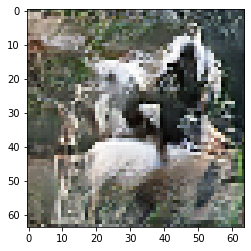

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 9

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 19.61533212661743 sec
Gen loss: 1.1829481471416563, Disc loss: 1.2219224821689516, Disc valid real loss: 0.5823474848686263, Disc valid fake loss: 0.5523442196291547, Disc class real loss: 0.030142946634103197, Disc class fake loss: 0.060081704803620635
Time for epoch 2 is 19.58219265937805 sec
Gen loss: 1.1857521506242974, Disc loss: 1.2173768018567286, Disc valid real loss: 0.5794327174161755, Disc valid fake loss: 0.5537958167666612, Disc class real loss: 0.03061098197915356, Disc class fake loss: 0.056056380288991084
Time for epoch 3 is 19.63220763206482 sec
Gen loss: 1.1701886251915332, Disc loss: 1.2099161764910056, Disc valid real loss: 0.5746769549888234, Disc valid fake loss: 0.5539533939472464, Disc class real loss: 0.03128775296804528, Disc class fake loss: 0.05203090225798004
Time for epoch 4 is 19.5980966091156 sec
Gen loss: 1.181770496936

Time for epoch 31 is 19.511144399642944 sec
Gen loss: 1.1817034576521364, Disc loss: 1.219280858372533, Disc valid real loss: 0.5765498382754104, Disc valid fake loss: 0.5552522950740748, Disc class real loss: 0.034065399869029726, Disc class fake loss: 0.05486962332149634
Time for epoch 32 is 19.52005958557129 sec
Gen loss: 1.184032370184743, Disc loss: 1.2032757605924163, Disc valid real loss: 0.5700959412511005, Disc valid fake loss: 0.5473087085194366, Disc class real loss: 0.03142100611402447, Disc class fake loss: 0.056156881102059596
Time for epoch 33 is 19.551244974136353 sec
Gen loss: 1.1984972673100094, Disc loss: 1.2005208702974541, Disc valid real loss: 0.576979186645774, Disc valid fake loss: 0.5493078687509825, Disc class real loss: 0.028204727400473233, Disc class fake loss: 0.04732957083480108
Time for epoch 34 is 19.624691247940063 sec
Gen loss: 1.1938505488079647, Disc loss: 1.1952944896941962, Disc valid real loss: 0.5730248642868774, Disc valid fake loss: 0.54668988

Time for epoch 61 is 19.54853081703186 sec
Gen loss: 1.1895141126804574, Disc loss: 1.1930774478025215, Disc valid real loss: 0.5720861626918926, Disc valid fake loss: 0.5540677383542061, Disc class real loss: 0.026483334185603634, Disc class fake loss: 0.041021752232810224
Time for epoch 62 is 19.560102462768555 sec
Gen loss: 1.208144976995712, Disc loss: 1.1963051505560098, Disc valid real loss: 0.574051516173884, Disc valid fake loss: 0.5388960694504339, Disc class real loss: 0.03562693786502783, Disc class fake loss: 0.04822182669014965
Time for epoch 63 is 19.55584144592285 sec
Gen loss: 1.1906690077726232, Disc loss: 1.201508416685947, Disc valid real loss: 0.5742538219621015, Disc valid fake loss: 0.5428298664994018, Disc class real loss: 0.028850571531821453, Disc class fake loss: 0.056629767243531776
Time for epoch 64 is 19.59993267059326 sec
Gen loss: 1.2010667403770048, Disc loss: 1.2046044375314269, Disc valid real loss: 0.5754603040079738, Disc valid fake loss: 0.549418268

Time for epoch 91 is 19.56741762161255 sec
Gen loss: 1.2097538678452027, Disc loss: 1.209284022450447, Disc valid real loss: 0.5792636055239412, Disc valid fake loss: 0.5449780055949854, Disc class real loss: 0.03479439590234485, Disc class fake loss: 0.05040411413083771
Time for epoch 92 is 19.57054829597473 sec
Gen loss: 1.2014988560316175, Disc loss: 1.192742453411568, Disc valid real loss: 0.5662389356036519, Disc valid fake loss: 0.5434234700230665, Disc class real loss: 0.03168256607327643, Disc class fake loss: 0.05157652851977578
Time for epoch 93 is 19.56997060775757 sec
Gen loss: 1.1913801805917608, Disc loss: 1.2055806978497394, Disc valid real loss: 0.5758804834859316, Disc valid fake loss: 0.5508991060561912, Disc class real loss: 0.03289514646962215, Disc class fake loss: 0.0460108881856878
Time for epoch 94 is 19.551525592803955 sec
Gen loss: 1.2029881404582845, Disc loss: 1.207988027223321, Disc valid real loss: 0.5721159262019534, Disc valid fake loss: 0.54150868276523

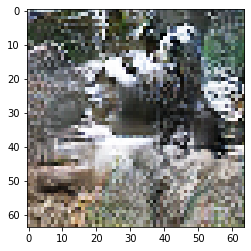

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 10

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 19.622904062271118 sec
Gen loss: 1.218104058919951, Disc loss: 1.2056029851353445, Disc valid real loss: 0.5710636536742366, Disc valid fake loss: 0.5435735392709111, Disc class real loss: 0.04086760814886454, Disc class fake loss: 0.05009818608820307
Time for epoch 2 is 19.380544900894165 sec
Gen loss: 1.2154006050076596, Disc loss: 1.2083689518446146, Disc valid real loss: 0.573412258611169, Disc valid fake loss: 0.5424103551479273, Disc class real loss: 0.03436048244779962, Disc class fake loss: 0.05818585591166697
Time for epoch 3 is 19.756404399871826 sec
Gen loss: 1.2181867510080338, Disc loss: 1.1953339365332625, Disc valid real loss: 0.5688573801240255, Disc valid fake loss: 0.5374307272046112, Disc class real loss: 0.030654083118618072, Disc class fake loss: 0.058391747036630685
Time for epoch 4 is 19.44252896308899 sec
Gen loss: 1.2032774482

Time for epoch 31 is 19.50131583213806 sec
Gen loss: 1.2191200169713, Disc loss: 1.203257446025693, Disc valid real loss: 0.565465628234453, Disc valid fake loss: 0.5412510779014853, Disc class real loss: 0.0399290552589708, Disc class fake loss: 0.0566116831393396
Time for epoch 32 is 19.521804094314575 sec
Gen loss: 1.2147587572419367, Disc loss: 1.207928562580153, Disc valid real loss: 0.5722648679863575, Disc valid fake loss: 0.5391919266345889, Disc class real loss: 0.03760087189804708, Disc class fake loss: 0.05887090042318071
Time for epoch 33 is 19.49362802505493 sec
Gen loss: 1.2130785050780275, Disc loss: 1.1952519680178442, Disc valid real loss: 0.5730786845088005, Disc valid fake loss: 0.5403038649711498, Disc class real loss: 0.030680402313559764, Disc class fake loss: 0.05118901805284157
Time for epoch 34 is 19.510723114013672 sec
Gen loss: 1.2177595925885578, Disc loss: 1.1941339134476905, Disc valid real loss: 0.5738595658263494, Disc valid fake loss: 0.5406349131534266

Time for epoch 61 is 19.5035662651062 sec
Gen loss: 1.2239778423032095, Disc loss: 1.1930439004371332, Disc valid real loss: 0.5690923262127611, Disc valid fake loss: 0.5423989670221195, Disc class real loss: 0.02474558024836327, Disc class fake loss: 0.056807029996995224
Time for epoch 62 is 19.546299695968628 sec
Gen loss: 1.2227759576121042, Disc loss: 1.1925937706647918, Disc valid real loss: 0.5683490975305091, Disc valid fake loss: 0.5421134924819303, Disc class real loss: 0.03316606448086447, Disc class fake loss: 0.04896511384694625
Time for epoch 63 is 19.503546476364136 sec
Gen loss: 1.2202750482531481, Disc loss: 1.1787956852552504, Disc valid real loss: 0.5669981788757236, Disc valid fake loss: 0.5420878101573434, Disc class real loss: 0.03233113211201779, Disc class fake loss: 0.03737856485523205
Time for epoch 64 is 19.502965927124023 sec
Gen loss: 1.2247119771186696, Disc loss: 1.1937198978523875, Disc valid real loss: 0.5619453974934512, Disc valid fake loss: 0.54846942

Time for epoch 91 is 19.485021352767944 sec
Gen loss: 1.21969220215498, Disc loss: 1.201397374618885, Disc valid real loss: 0.5742544057064278, Disc valid fake loss: 0.5389408597419428, Disc class real loss: 0.03992514096463247, Disc class fake loss: 0.048276965428623614
Time for epoch 92 is 19.484964609146118 sec
Gen loss: 1.236810522717099, Disc loss: 1.177694929547088, Disc valid real loss: 0.5590224188081053, Disc valid fake loss: 0.5356561863838241, Disc class real loss: 0.03211693613610445, Disc class fake loss: 0.05089938912740678
Time for epoch 93 is 19.560970544815063 sec
Gen loss: 1.2444047709537107, Disc loss: 1.1803281123554983, Disc valid real loss: 0.558618348525014, Disc valid fake loss: 0.535720179420571, Disc class real loss: 0.030538681393747623, Disc class fake loss: 0.05545090667214407
Time for epoch 94 is 19.505685567855835 sec
Gen loss: 1.2358193601979766, Disc loss: 1.1880039066769357, Disc valid real loss: 0.5661922918502674, Disc valid fake loss: 0.541946060608

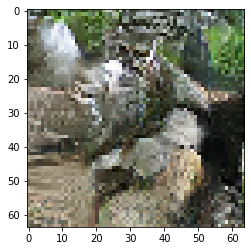

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 11

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 19.530207633972168 sec
Gen loss: 1.23787072543488, Disc loss: 1.1866218565508377, Disc valid real loss: 0.5710316903369371, Disc valid fake loss: 0.5354681394474451, Disc class real loss: 0.02851308878209323, Disc class fake loss: 0.051608937453344224
Time for epoch 2 is 19.463685274124146 sec
Gen loss: 1.239079387728558, Disc loss: 1.1879182509904684, Disc valid real loss: 0.5681341716716456, Disc valid fake loss: 0.5371029921049295, Disc class real loss: 0.029601000027807543, Disc class fake loss: 0.05308008423280837
Time for epoch 3 is 19.420400857925415 sec
Gen loss: 1.2300051759148753, Disc loss: 1.176456163442412, Disc valid real loss: 0.5740664012210314, Disc valid fake loss: 0.5338758852246196, Disc class real loss: 0.031147556189543412, Disc class fake loss: 0.03736632293712742
Time for epoch 4 is 19.43791675567627 sec
Gen loss: 1.21434136497

Time for epoch 31 is 19.560076475143433 sec
Gen loss: 1.2611155333214028, Disc loss: 1.2017098779595174, Disc valid real loss: 0.5734382394787877, Disc valid fake loss: 0.535083377777144, Disc class real loss: 0.03265544043934761, Disc class fake loss: 0.060532824333444465
Time for epoch 32 is 19.551334381103516 sec
Gen loss: 1.2455746860698211, Disc loss: 1.1631531736185385, Disc valid real loss: 0.554538375763006, Disc valid fake loss: 0.5375952325588049, Disc class real loss: 0.028016235511364188, Disc class fake loss: 0.043003336276025185
Time for epoch 33 is 19.566494703292847 sec
Gen loss: 1.2379625259443772, Disc loss: 1.1948552582153054, Disc valid real loss: 0.5685729488383892, Disc valid fake loss: 0.5410698702515557, Disc class real loss: 0.0323768967317487, Disc class fake loss: 0.05283554663384526
Time for epoch 34 is 19.55753445625305 sec
Gen loss: 1.2539165896731754, Disc loss: 1.1828620468461237, Disc valid real loss: 0.5595897370299627, Disc valid fake loss: 0.53524676

Time for epoch 61 is 19.5823175907135 sec
Gen loss: 1.2591394657312438, Disc loss: 1.1831827572611875, Disc valid real loss: 0.567772529846014, Disc valid fake loss: 0.5363815113209015, Disc class real loss: 0.027775273617598305, Disc class fake loss: 0.05125344076999639
Time for epoch 62 is 19.5580313205719 sec
Gen loss: 1.256584453721379, Disc loss: 1.1755065838264864, Disc valid real loss: 0.5635769893956739, Disc valid fake loss: 0.5330902225402898, Disc class real loss: 0.02652115953224195, Disc class fake loss: 0.052318214074550146
Time for epoch 63 is 19.553427696228027 sec
Gen loss: 1.2647550594668056, Disc loss: 1.1619262553231662, Disc valid real loss: 0.5586438776795254, Disc valid fake loss: 0.5263586815359981, Disc class real loss: 0.03493172074305158, Disc class fake loss: 0.04199196866176313
Time for epoch 64 is 19.544414281845093 sec
Gen loss: 1.2483833321305209, Disc loss: 1.1720170260861862, Disc valid real loss: 0.5596339792706245, Disc valid fake loss: 0.53604151273

Time for epoch 91 is 19.672008752822876 sec
Gen loss: 1.2543735105630964, Disc loss: 1.17349668990734, Disc valid real loss: 0.5636597802472669, Disc valid fake loss: 0.5378270433392636, Disc class real loss: 0.027980771563137708, Disc class fake loss: 0.044029087192537314
Time for epoch 92 is 19.479305505752563 sec
Gen loss: 1.2636104305816251, Disc loss: 1.168897693586904, Disc valid real loss: 0.5638051632531854, Disc valid fake loss: 0.5264609029819799, Disc class real loss: 0.028760765441865958, Disc class fake loss: 0.0498708633884996
Time for epoch 93 is 19.60547184944153 sec
Gen loss: 1.2537305029325707, Disc loss: 1.1667285481857699, Disc valid real loss: 0.55653452613326, Disc valid fake loss: 0.5284684515276621, Disc class real loss: 0.034981843218448314, Disc class fake loss: 0.0467437318441012
Time for epoch 94 is 19.50493884086609 sec
Gen loss: 1.2681152751279432, Disc loss: 1.1472043606430986, Disc valid real loss: 0.555326446371023, Disc valid fake loss: 0.5242116018090

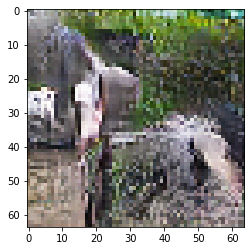

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 12

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 19.60831308364868 sec
Gen loss: 1.2479402190724085, Disc loss: 1.1919972681721975, Disc valid real loss: 0.5706857442855835, Disc valid fake loss: 0.5342241073417109, Disc class real loss: 0.028012862577503087, Disc class fake loss: 0.0590745576118511
Time for epoch 2 is 19.58371329307556 sec
Gen loss: 1.2507343219463216, Disc loss: 1.1870182773401572, Disc valid real loss: 0.5698813591585603, Disc valid fake loss: 0.5371719033912171, Disc class real loss: 0.03270614821377781, Disc class fake loss: 0.04725886584263969
Time for epoch 3 is 19.427064418792725 sec
Gen loss: 1.2512115354454794, Disc loss: 1.1613197506860244, Disc valid real loss: 0.5560490553115689, Disc valid fake loss: 0.5351709026929944, Disc class real loss: 0.027129278479933842, Disc class fake loss: 0.042970512316292855
Time for epoch 4 is 19.71793818473816 sec
Gen loss: 1.2555220151

Time for epoch 31 is 19.52958035469055 sec
Gen loss: 1.2745760509441064, Disc loss: 1.166744618914848, Disc valid real loss: 0.5540472667577655, Disc valid fake loss: 0.5379483197317567, Disc class real loss: 0.02956211440989644, Disc class fake loss: 0.045186920451331304
Time for epoch 32 is 19.525394201278687 sec
Gen loss: 1.2656367687984955, Disc loss: 1.1619993541822877, Disc valid real loss: 0.5626214934989463, Disc valid fake loss: 0.532622140334096, Disc class real loss: 0.0262827495397962, Disc class fake loss: 0.04047297780959715
Time for epoch 33 is 19.528279304504395 sec
Gen loss: 1.2889959257702495, Disc loss: 1.1407913749301157, Disc valid real loss: 0.546927114905313, Disc valid fake loss: 0.5270192125855491, Disc class real loss: 0.02361914637323173, Disc class fake loss: 0.043225904560067856
Time for epoch 34 is 19.589951515197754 sec
Gen loss: 1.2701232939265494, Disc loss: 1.1638769781173661, Disc valid real loss: 0.5662348291208578, Disc valid fake loss: 0.5300856094

Time for epoch 61 is 19.548337697982788 sec
Gen loss: 1.29414778739907, Disc loss: 1.1501200964977576, Disc valid real loss: 0.5513689677382625, Disc valid fake loss: 0.5222607728007228, Disc class real loss: 0.03217871822600373, Disc class fake loss: 0.04431162752041209
Time for epoch 62 is 19.544286489486694 sec
Gen loss: 1.2865783225658327, Disc loss: 1.1605648017206858, Disc valid real loss: 0.5595336355442224, Disc valid fake loss: 0.5264602078254833, Disc class real loss: 0.026887999239375477, Disc class fake loss: 0.04768295896834854
Time for epoch 63 is 19.507944583892822 sec
Gen loss: 1.2813730731953021, Disc loss: 1.1602845871171286, Disc valid real loss: 0.55581063101458, Disc valid fake loss: 0.5233571733846221, Disc class real loss: 0.03140632312766514, Disc class fake loss: 0.04971046057539223
Time for epoch 64 is 19.52334213256836 sec
Gen loss: 1.2693659760231195, Disc loss: 1.167246718046277, Disc valid real loss: 0.5519592055054598, Disc valid fake loss: 0.545187621442

Time for epoch 91 is 19.539496898651123 sec
Gen loss: 1.2915192565252616, Disc loss: 1.1602090711510458, Disc valid real loss: 0.5569479035776715, Disc valid fake loss: 0.5297521728762361, Disc class real loss: 0.028018838853947885, Disc class fake loss: 0.04549015402102838
Time for epoch 92 is 19.537503004074097 sec
Gen loss: 1.2867164334585501, Disc loss: 1.1483676069697668, Disc valid real loss: 0.5489530367560165, Disc valid fake loss: 0.5235635173875232, Disc class real loss: 0.03466647314436096, Disc class fake loss: 0.04118458054434213
Time for epoch 93 is 19.53336453437805 sec
Gen loss: 1.2946609057659326, Disc loss: 1.1569336153740106, Disc valid real loss: 0.5595385589918425, Disc valid fake loss: 0.5252797411278237, Disc class real loss: 0.02857586605683156, Disc class fake loss: 0.043539444911677785
Time for epoch 94 is 19.566848039627075 sec
Gen loss: 1.2836402550686237, Disc loss: 1.1429192569366722, Disc valid real loss: 0.5511127862819406, Disc valid fake loss: 0.529308

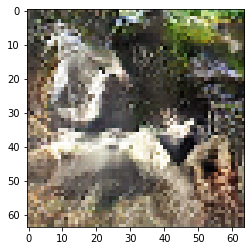

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 13

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 19.571528434753418 sec
Gen loss: 1.2922903618147208, Disc loss: 1.1522876460884892, Disc valid real loss: 0.5594549840965937, Disc valid fake loss: 0.520191409560137, Disc class real loss: 0.03052623177139795, Disc class fake loss: 0.04211502224228922
Time for epoch 2 is 19.56153964996338 sec
Gen loss: 1.2780268303183622, Disc loss: 1.175639089803363, Disc valid real loss: 0.5711869425898375, Disc valid fake loss: 0.5252165295356928, Disc class real loss: 0.028049098252394773, Disc class fake loss: 0.051186524204726885
Time for epoch 3 is 19.537231922149658 sec
Gen loss: 1.2807589204505432, Disc loss: 1.1540718463271162, Disc valid real loss: 0.5524804320099742, Disc valid fake loss: 0.5282468295028043, Disc class real loss: 0.02859621814609137, Disc class fake loss: 0.0447483675811253
Time for epoch 4 is 19.552568197250366 sec
Gen loss: 1.27319966776

Time for epoch 31 is 19.711487293243408 sec
Gen loss: 1.3000040712744692, Disc loss: 1.1663582858651182, Disc valid real loss: 0.5600214170855146, Disc valid fake loss: 0.5259278958966566, Disc class real loss: 0.03313055575402592, Disc class fake loss: 0.047278419957492164
Time for epoch 32 is 19.646869897842407 sec
Gen loss: 1.305631198508795, Disc loss: 1.1375882095375727, Disc valid real loss: 0.543467330204886, Disc valid fake loss: 0.5177742660392163, Disc class real loss: 0.031129854429076828, Disc class fake loss: 0.0452167606556116
Time for epoch 33 is 19.583881378173828 sec
Gen loss: 1.2938602417707443, Disc loss: 1.1496686332447583, Disc valid real loss: 0.5537209088026092, Disc valid fake loss: 0.5299256750664045, Disc class real loss: 0.026709112119258565, Disc class fake loss: 0.039312942149144665
Time for epoch 34 is 19.59533190727234 sec
Gen loss: 1.283156583475512, Disc loss: 1.1739942670561547, Disc valid real loss: 0.5577492140406786, Disc valid fake loss: 0.53133274

Time for epoch 61 is 19.46500539779663 sec
Gen loss: 1.2969325600668442, Disc loss: 1.1437836351782777, Disc valid real loss: 0.5555702148135319, Disc valid fake loss: 0.5235295167496038, Disc class real loss: 0.02979859949651697, Disc class fake loss: 0.034885306521975384
Time for epoch 62 is 19.54731011390686 sec
Gen loss: 1.319257770859918, Disc loss: 1.1644808348528175, Disc valid real loss: 0.5520154906566753, Disc valid fake loss: 0.5268860019223635, Disc class real loss: 0.0316321891571343, Disc class fake loss: 0.05394714812351848
Time for epoch 63 is 19.658828735351562 sec
Gen loss: 1.303682257269704, Disc loss: 1.1344427923823512, Disc valid real loss: 0.5508987874139187, Disc valid fake loss: 0.515057903909406, Disc class real loss: 0.025607952018659955, Disc class fake loss: 0.04287815014677742
Time for epoch 64 is 19.374064445495605 sec
Gen loss: 1.288737026757972, Disc loss: 1.1660718678735023, Disc valid real loss: 0.556283874047357, Disc valid fake loss: 0.5305997642666

Time for epoch 91 is 19.53473210334778 sec
Gen loss: 1.301120845384376, Disc loss: 1.1531568079493766, Disc valid real loss: 0.5598076666856922, Disc valid fake loss: 0.5240502052528914, Disc class real loss: 0.027305735758091032, Disc class fake loss: 0.041993199056970444
Time for epoch 92 is 19.544880628585815 sec
Gen loss: 1.3102543180765107, Disc loss: 1.147330110156259, Disc valid real loss: 0.539449135058148, Disc valid fake loss: 0.5233198179062023, Disc class real loss: 0.033508520638142095, Disc class fake loss: 0.05105264304176333
Time for epoch 93 is 19.54367232322693 sec
Gen loss: 1.3036374390818353, Disc loss: 1.1413003888934157, Disc valid real loss: 0.5505825288073961, Disc valid fake loss: 0.5201029709951822, Disc class real loss: 0.030190153202691066, Disc class fake loss: 0.04042474077847823
Time for epoch 94 is 19.5737624168396 sec
Gen loss: 1.3107876694479654, Disc loss: 1.149424605244814, Disc valid real loss: 0.5542273722415747, Disc valid fake loss: 0.51688482335

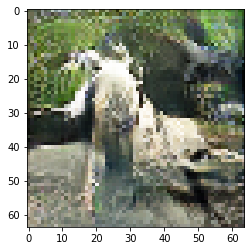

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 14

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 19.529160499572754 sec
Gen loss: 1.3088903305835502, Disc loss: 1.1574787615343582, Disc valid real loss: 0.5574832276202911, Disc valid fake loss: 0.5245698347341182, Disc class real loss: 0.034924786092169806, Disc class fake loss: 0.04050091196222638
Time for epoch 2 is 19.543320417404175 sec
Gen loss: 1.311212527890538, Disc loss: 1.145853310476902, Disc valid real loss: 0.5458269924965016, Disc valid fake loss: 0.526421975950862, Disc class real loss: 0.023383907083392164, Disc class fake loss: 0.0502204391006756
Time for epoch 3 is 19.559499979019165 sec
Gen loss: 1.323880525522454, Disc loss: 1.1265683738991272, Disc valid real loss: 0.5416397540721782, Disc valid fake loss: 0.5156781952394995, Disc class real loss: 0.021867884717742758, Disc class fake loss: 0.047382545115227874
Time for epoch 4 is 19.53062343597412 sec
Gen loss: 1.33764688150

Time for epoch 31 is 19.60211157798767 sec
Gen loss: 1.316404766121576, Disc loss: 1.148148076478825, Disc valid real loss: 0.5504670221098634, Disc valid fake loss: 0.5237557768475177, Disc class real loss: 0.02808155771298368, Disc class fake loss: 0.04584372107968002
Time for epoch 32 is 19.55590510368347 sec
Gen loss: 1.3307558145633964, Disc loss: 1.1209503259769706, Disc valid real loss: 0.5405617361498434, Disc valid fake loss: 0.5097911390800809, Disc class real loss: 0.02850849257561623, Disc class fake loss: 0.04208896181097411
Time for epoch 33 is 19.55315899848938 sec
Gen loss: 1.321775413876356, Disc loss: 1.1615663420322329, Disc valid real loss: 0.5612939920189769, Disc valid fake loss: 0.5207145933148473, Disc class real loss: 0.03117825065305095, Disc class fake loss: 0.04837950413503825
Time for epoch 34 is 19.54736852645874 sec
Gen loss: 1.3126857634200606, Disc loss: 1.1228837959988172, Disc valid real loss: 0.539093381963497, Disc valid fake loss: 0.518432899269946

Time for epoch 61 is 19.720662355422974 sec
Gen loss: 1.3326866689116457, Disc loss: 1.1522763832363971, Disc valid real loss: 0.5437105641115544, Disc valid fake loss: 0.5223683825759, Disc class real loss: 0.04078421030325719, Disc class fake loss: 0.0454132232416034
Time for epoch 62 is 19.54256296157837 sec
Gen loss: 1.3310794643191404, Disc loss: 1.1319604765537172, Disc valid real loss: 0.5502957174944323, Disc valid fake loss: 0.5206745781524237, Disc class real loss: 0.02449457857735894, Disc class fake loss: 0.03649560169626141
Time for epoch 63 is 19.55280041694641 sec
Gen loss: 1.3496572084205096, Disc loss: 1.1154637336730957, Disc valid real loss: 0.5419597222014915, Disc valid fake loss: 0.5122715184508368, Disc class real loss: 0.03040077037738144, Disc class fake loss: 0.030831723125904615
Time for epoch 64 is 19.700831651687622 sec
Gen loss: 1.3291925884956537, Disc loss: 1.1458548972772997, Disc valid real loss: 0.5565579977146414, Disc valid fake loss: 0.518401775422

Time for epoch 91 is 19.534605264663696 sec
Gen loss: 1.3171168364757715, Disc loss: 1.1672956330138584, Disc valid real loss: 0.5632026264833849, Disc valid fake loss: 0.5180254474628804, Disc class real loss: 0.0350728257188293, Disc class fake loss: 0.050994731948713005
Time for epoch 92 is 19.67516040802002 sec
Gen loss: 1.311601430870766, Disc loss: 1.13051134001377, Disc valid real loss: 0.5471470787428147, Disc valid fake loss: 0.5123941820374754, Disc class real loss: 0.02668038114935307, Disc class fake loss: 0.04428970281168044
Time for epoch 93 is 19.630836963653564 sec
Gen loss: 1.328312409132026, Disc loss: 1.1350573114184446, Disc valid real loss: 0.5539640543419261, Disc valid fake loss: 0.5148815344585929, Disc class real loss: 0.025954019414923604, Disc class fake loss: 0.040257704341097135
Time for epoch 94 is 19.644299745559692 sec
Gen loss: 1.3249369180479715, Disc loss: 1.1384201673574226, Disc valid real loss: 0.5458789753705956, Disc valid fake loss: 0.5215495807

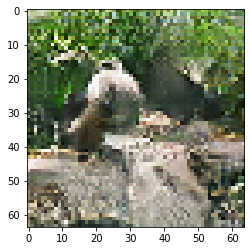

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 15

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 19.495924711227417 sec
Gen loss: 1.3274141161940818, Disc loss: 1.13496779078661, Disc valid real loss: 0.5522994362684184, Disc valid fake loss: 0.5254553793821224, Disc class real loss: 0.02456580539221123, Disc class fake loss: 0.0326471753799122
Time for epoch 2 is 19.697601079940796 sec
Gen loss: 1.3169415496116461, Disc loss: 1.1632510486037233, Disc valid real loss: 0.5569457323398701, Disc valid fake loss: 0.5253621996488682, Disc class real loss: 0.02715737319922059, Disc class fake loss: 0.053785746407726924
Time for epoch 3 is 19.439289569854736 sec
Gen loss: 1.3305822797985964, Disc loss: 1.1200782996277476, Disc valid real loss: 0.5366022579891737, Disc valid fake loss: 0.519732573004656, Disc class real loss: 0.02609462528886958, Disc class fake loss: 0.03764884650682202
Time for epoch 4 is 19.596622705459595 sec
Gen loss: 1.344892151827

Time for epoch 31 is 19.6056387424469 sec
Gen loss: 1.3503639115843662, Disc loss: 1.1273073242154232, Disc valid real loss: 0.5495915253495061, Disc valid fake loss: 0.5133061920141064, Disc class real loss: 0.026497516060327714, Disc class fake loss: 0.037912093326371556
Time for epoch 32 is 19.581328630447388 sec
Gen loss: 1.3454397771247597, Disc loss: 1.1178209736596707, Disc valid real loss: 0.5365977401650229, Disc valid fake loss: 0.5094650398160137, Disc class real loss: 0.028688783357295525, Disc class fake loss: 0.04306940888437926
Time for epoch 33 is 19.66769814491272 sec
Gen loss: 1.3503182544264682, Disc loss: 1.1400568308525307, Disc valid real loss: 0.5500129573913508, Disc valid fake loss: 0.513535201029722, Disc class real loss: 0.034572817814266674, Disc class fake loss: 0.04193586100212426
Time for epoch 34 is 19.516297817230225 sec
Gen loss: 1.3485933819482492, Disc loss: 1.1107283747473429, Disc valid real loss: 0.5467159548817679, Disc valid fake loss: 0.5099840

Time for epoch 61 is 19.567569494247437 sec
Gen loss: 1.334185637706934, Disc loss: 1.148848644869272, Disc valid real loss: 0.5465100788792898, Disc valid fake loss: 0.5267591926940652, Disc class real loss: 0.028394052764164117, Disc class fake loss: 0.04718532126537676
Time for epoch 62 is 19.577948331832886 sec
Gen loss: 1.3520736507205076, Disc loss: 1.1291137043126793, Disc valid real loss: 0.5473749720773031, Disc valid fake loss: 0.5088058257865351, Disc class real loss: 0.030732928837731082, Disc class fake loss: 0.04219997711215699
Time for epoch 63 is 19.555569648742676 sec
Gen loss: 1.3245172140210173, Disc loss: 1.140286652847778, Disc valid real loss: 0.5441301225922829, Disc valid fake loss: 0.5193625539541245, Disc class real loss: 0.03655273799849542, Disc class fake loss: 0.04024124577103236
Time for epoch 64 is 19.589837551116943 sec
Gen loss: 1.357593457366145, Disc loss: 1.1177979219098424, Disc valid real loss: 0.5393728806182395, Disc valid fake loss: 0.515069233

Time for epoch 91 is 19.545615434646606 sec
Gen loss: 1.3162449161673702, Disc loss: 1.1325635792211044, Disc valid real loss: 0.5540195391621701, Disc valid fake loss: 0.5236576681220254, Disc class real loss: 0.02056522989935962, Disc class fake loss: 0.03432114091648082
Time for epoch 92 is 19.568963766098022 sec
Gen loss: 1.3321100154588388, Disc loss: 1.1212176115706909, Disc valid real loss: 0.5369431168534035, Disc valid fake loss: 0.514028359117896, Disc class real loss: 0.024724491641114413, Disc class fake loss: 0.04552164623579978
Time for epoch 93 is 19.554949045181274 sec
Gen loss: 1.3490965941617654, Disc loss: 1.1425156271041825, Disc valid real loss: 0.5407211894905845, Disc valid fake loss: 0.515043647656607, Disc class real loss: 0.039856033976151554, Disc class fake loss: 0.04689476382614081
Time for epoch 94 is 19.563134908676147 sec
Gen loss: 1.3242891784324202, Disc loss: 1.141995520439259, Disc valid real loss: 0.5515001083529273, Disc valid fake loss: 0.51487223

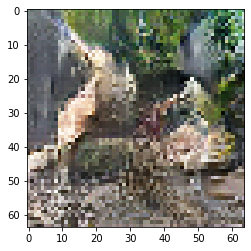

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 16

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 19.518420457839966 sec
Gen loss: 1.3367213322672733, Disc loss: 1.1498288092918174, Disc valid real loss: 0.5518305331122043, Disc valid fake loss: 0.5242726444158443, Disc class real loss: 0.028364177160467588, Disc class fake loss: 0.04536145989744867
Time for epoch 2 is 19.46968913078308 sec
Gen loss: 1.3600473993046338, Disc loss: 1.1254409672909005, Disc valid real loss: 0.5417419907658599, Disc valid fake loss: 0.5146037643385488, Disc class real loss: 0.02698143721089616, Disc class fake loss: 0.04211377548946012
Time for epoch 3 is 19.485374450683594 sec
Gen loss: 1.3444890081882477, Disc loss: 1.1108181431542996, Disc valid real loss: 0.5479828992555308, Disc valid fake loss: 0.5104199025866597, Disc class real loss: 0.019578976342017995, Disc class fake loss: 0.032836365685038484
Time for epoch 4 is 19.64439105987549 sec
Gen loss: 1.34031146

Time for epoch 31 is 19.49768614768982 sec
Gen loss: 1.353042608776758, Disc loss: 1.121118744098863, Disc valid real loss: 0.546224755776483, Disc valid fake loss: 0.5098493424958961, Disc class real loss: 0.021394649125330373, Disc class fake loss: 0.04364999725609334
Time for epoch 32 is 19.506991147994995 sec
Gen loss: 1.3590539683436238, Disc loss: 1.116124734975571, Disc valid real loss: 0.5360865939495175, Disc valid fake loss: 0.5085639104593632, Disc class real loss: 0.027488891701211268, Disc class fake loss: 0.043985336986224866
Time for epoch 33 is 19.659730195999146 sec
Gen loss: 1.3438921681670255, Disc loss: 1.1126139167436333, Disc valid real loss: 0.5468842515418696, Disc valid fake loss: 0.5122159620703652, Disc class real loss: 0.021440914057039177, Disc class fake loss: 0.03207278806113991
Time for epoch 34 is 19.7146098613739 sec
Gen loss: 1.3720774130765783, Disc loss: 1.1119136273167853, Disc valid real loss: 0.5376908922957819, Disc valid fake loss: 0.5033993863

Time for epoch 61 is 19.520556926727295 sec
Gen loss: 1.351841892613921, Disc loss: 1.1349835274524467, Disc valid real loss: 0.5399130092457284, Disc valid fake loss: 0.5224959424068761, Disc class real loss: 0.033276240228778356, Disc class fake loss: 0.03929833382290929
Time for epoch 62 is 19.51613974571228 sec
Gen loss: 1.3400444928989854, Disc loss: 1.1470405293065449, Disc valid real loss: 0.5537857638542042, Disc valid fake loss: 0.5189087280007296, Disc class real loss: 0.02629304145952923, Disc class fake loss: 0.048052992385639176
Time for epoch 63 is 19.5394389629364 sec
Gen loss: 1.3511440833640653, Disc loss: 1.1170580203450002, Disc valid real loss: 0.5372258251489594, Disc valid fake loss: 0.5087286842077278, Disc class real loss: 0.027636607420961724, Disc class fake loss: 0.04346690546083474
Time for epoch 64 is 19.542430877685547 sec
Gen loss: 1.350255088057629, Disc loss: 1.1339895181184592, Disc valid real loss: 0.5490535913511764, Disc valid fake loss: 0.519620982

Time for epoch 91 is 19.50385355949402 sec
Gen loss: 1.3598127780958664, Disc loss: 1.143688548789468, Disc valid real loss: 0.5533955435073653, Disc valid fake loss: 0.5130304995664331, Disc class real loss: 0.028500526850652828, Disc class fake loss: 0.0487619762039516
Time for epoch 92 is 19.470590591430664 sec
Gen loss: 1.3471435953018278, Disc loss: 1.1297773264868314, Disc valid real loss: 0.5376965802076251, Disc valid fake loss: 0.5082223645822946, Disc class real loss: 0.03595870690861735, Disc class fake loss: 0.04789967087556359
Time for epoch 93 is 19.502917051315308 sec
Gen loss: 1.37319192567537, Disc loss: 1.1120897819136464, Disc valid real loss: 0.5378688996614411, Disc valid fake loss: 0.5115969000860702, Disc class real loss: 0.023996447809305356, Disc class fake loss: 0.03862753690877663
Time for epoch 94 is 19.54879927635193 sec
Gen loss: 1.3832233076871827, Disc loss: 1.1037855356238608, Disc valid real loss: 0.5339127754749253, Disc valid fake loss: 0.50504256507

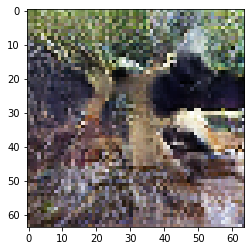

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 17

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 19.491873025894165 sec
Gen loss: 1.341577288023261, Disc loss: 1.142380454165991, Disc valid real loss: 0.5497451081525447, Disc valid fake loss: 0.5158251504911933, Disc class real loss: 0.030209937355763498, Disc class fake loss: 0.04660025974914767
Time for epoch 2 is 19.50227117538452 sec
Gen loss: 1.3698702905067177, Disc loss: 1.121708398641542, Disc valid real loss: 0.5381899637191795, Disc valid fake loss: 0.5120156204631162, Disc class real loss: 0.03210012747578815, Disc class fake loss: 0.039402688754328896
Time for epoch 3 is 19.491524696350098 sec
Gen loss: 1.358824756949447, Disc loss: 1.121899473112683, Disc valid real loss: 0.5357045212457346, Disc valid fake loss: 0.512142283105573, Disc class real loss: 0.028480865563308325, Disc class fake loss: 0.04557180271601896
Time for epoch 4 is 19.502468585968018 sec
Gen loss: 1.3697729013686

Time for epoch 31 is 19.58036756515503 sec
Gen loss: 1.354598194360733, Disc loss: 1.1218960264394449, Disc valid real loss: 0.5482223475741785, Disc valid fake loss: 0.5104596968307051, Disc class real loss: 0.02465320465451568, Disc class fake loss: 0.03856077046082138
Time for epoch 32 is 19.55525255203247 sec
Gen loss: 1.357083944387214, Disc loss: 1.111516072306522, Disc valid real loss: 0.5437634287531986, Disc valid fake loss: 0.5016527525907339, Disc class real loss: 0.026219721347610345, Disc class fake loss: 0.039880168162029765
Time for epoch 33 is 19.59702754020691 sec
Gen loss: 1.3750104342782221, Disc loss: 1.1177270356998887, Disc valid real loss: 0.5498541936624882, Disc valid fake loss: 0.5065766396217568, Disc class real loss: 0.02405538862785761, Disc class fake loss: 0.037240812223730206
Time for epoch 34 is 19.546696424484253 sec
Gen loss: 1.3637173536211946, Disc loss: 1.1191461037757784, Disc valid real loss: 0.5347813802749611, Disc valid fake loss: 0.5051857110

Time for epoch 61 is 19.533198595046997 sec
Gen loss: 1.370048312600269, Disc loss: 1.1229789901611418, Disc valid real loss: 0.5370950674594834, Disc valid fake loss: 0.5068223942504373, Disc class real loss: 0.03143180145770372, Disc class fake loss: 0.04762972506688489
Time for epoch 62 is 19.576641082763672 sec
Gen loss: 1.385141950707103, Disc loss: 1.1208668420481127, Disc valid real loss: 0.5383299842130306, Disc valid fake loss: 0.514734341827936, Disc class real loss: 0.02796341357411303, Disc class fake loss: 0.03983910596570092
Time for epoch 63 is 19.53111958503723 sec
Gen loss: 1.3806918318881545, Disc loss: 1.0995523583057314, Disc valid real loss: 0.5287090962709382, Disc valid fake loss: 0.49970457962779113, Disc class real loss: 0.022557929064453485, Disc class fake loss: 0.04858075356626847
Time for epoch 64 is 19.56307554244995 sec
Gen loss: 1.380336970090866, Disc loss: 1.1284969823304998, Disc valid real loss: 0.5390349855256635, Disc valid fake loss: 0.51603372810

Time for epoch 91 is 19.494325160980225 sec
Gen loss: 1.3801168938015782, Disc loss: 1.1122943932233855, Disc valid real loss: 0.5450907895384833, Disc valid fake loss: 0.509052092426045, Disc class real loss: 0.018760694304718484, Disc class fake loss: 0.039390813645981286
Time for epoch 92 is 19.572096586227417 sec
Gen loss: 1.3839729705522226, Disc loss: 1.0937897711992264, Disc valid real loss: 0.5279921917028205, Disc valid fake loss: 0.5071251056222028, Disc class real loss: 0.022100751445091295, Disc class fake loss: 0.03657171343793168
Time for epoch 93 is 19.524906158447266 sec
Gen loss: 1.3797164892041407, Disc loss: 1.1308876258689304, Disc valid real loss: 0.5433127852373345, Disc valid fake loss: 0.5074294954538345, Disc class real loss: 0.03888806253262585, Disc class fake loss: 0.04125728603287635
Time for epoch 94 is 19.52871608734131 sec
Gen loss: 1.3797641500484112, Disc loss: 1.1103622507910396, Disc valid real loss: 0.5369553914250329, Disc valid fake loss: 0.496003

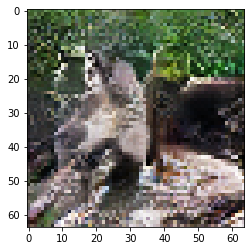

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 18

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 19.528080701828003 sec
Gen loss: 1.3854317283907602, Disc loss: 1.1119608182546705, Disc valid real loss: 0.5361469258056131, Disc valid fake loss: 0.5047996678324633, Disc class real loss: 0.030456949315605945, Disc class fake loss: 0.040557271060543125
Time for epoch 2 is 19.513027667999268 sec
Gen loss: 1.3964674694593562, Disc loss: 1.1159958537927894, Disc valid real loss: 0.5346348223298095, Disc valid fake loss: 0.5098495556171551, Disc class real loss: 0.028858892019893258, Disc class fake loss: 0.04265258192280334
Time for epoch 3 is 19.43970561027527 sec
Gen loss: 1.3851519247820212, Disc loss: 1.1137314844270085, Disc valid real loss: 0.5324400127973667, Disc valid fake loss: 0.503451792133409, Disc class real loss: 0.031327292374192246, Disc class fake loss: 0.046512385104760204
Time for epoch 4 is 19.43903946876526 sec
Gen loss: 1.3853317

Time for epoch 31 is 19.524417400360107 sec
Gen loss: 1.3864714440911314, Disc loss: 1.1146426890478578, Disc valid real loss: 0.5415233068687971, Disc valid fake loss: 0.5119666488364686, Disc class real loss: 0.021323052727597696, Disc class fake loss: 0.039829676907640194
Time for epoch 32 is 19.517059803009033 sec
Gen loss: 1.3708461682463802, Disc loss: 1.1091321183498515, Disc valid real loss: 0.5352234490389047, Disc valid fake loss: 0.5071722795796949, Disc class real loss: 0.025635659541580407, Disc class fake loss: 0.04110073095935784
Time for epoch 33 is 19.506150007247925 sec
Gen loss: 1.3771105997784192, Disc loss: 1.1492932719546696, Disc valid real loss: 0.5462536714797797, Disc valid fake loss: 0.509832038435825, Disc class real loss: 0.03287524250386331, Disc class fake loss: 0.06033232457860343
Time for epoch 34 is 19.610342025756836 sec
Gen loss: 1.3671339410682057, Disc loss: 1.102771820370541, Disc valid real loss: 0.5307216242302296, Disc valid fake loss: 0.504254

Time for epoch 61 is 19.553589344024658 sec
Gen loss: 1.3746776844179907, Disc loss: 1.1361920417741287, Disc valid real loss: 0.5469780186581057, Disc valid fake loss: 0.5145258688649466, Disc class real loss: 0.027533873236078824, Disc class fake loss: 0.047154276728940396
Time for epoch 62 is 19.531346082687378 sec
Gen loss: 1.3608604808186375, Disc loss: 1.1253181935049767, Disc valid real loss: 0.5449904562082402, Disc valid fake loss: 0.5092634964127873, Disc class real loss: 0.03202272182453842, Disc class fake loss: 0.039041524389049724
Time for epoch 63 is 19.559097290039062 sec
Gen loss: 1.364021821770557, Disc loss: 1.1397211631370145, Disc valid real loss: 0.539183282574942, Disc valid fake loss: 0.5125862243910169, Disc class real loss: 0.03564291817391952, Disc class fake loss: 0.052308739128886034
Time for epoch 64 is 19.564947605133057 sec
Gen loss: 1.371846396562665, Disc loss: 1.1095171525727872, Disc valid real loss: 0.5391052554166594, Disc valid fake loss: 0.508669

Time for epoch 91 is 19.572888135910034 sec
Gen loss: 1.3917122129784074, Disc loss: 1.1321064538733905, Disc valid real loss: 0.5285239178080892, Disc valid fake loss: 0.5126090874505598, Disc class real loss: 0.0416309697253636, Disc class fake loss: 0.04934247557253531
Time for epoch 92 is 19.618422269821167 sec
Gen loss: 1.3976978597252867, Disc loss: 1.1277033094056816, Disc valid real loss: 0.536068840255571, Disc valid fake loss: 0.5065333846696588, Disc class real loss: 0.03389400984238015, Disc class fake loss: 0.05120707207843648
Time for epoch 93 is 19.565503120422363 sec
Gen loss: 1.3768021270286206, Disc loss: 1.1145499390225078, Disc valid real loss: 0.5412193755077761, Disc valid fake loss: 0.5107260755328245, Disc class real loss: 0.02270415047538801, Disc class fake loss: 0.03990033623538397
Time for epoch 94 is 19.74005651473999 sec
Gen loss: 1.3785384020140006, Disc loss: 1.1063718913599503, Disc valid real loss: 0.5257842665494874, Disc valid fake loss: 0.5056933810

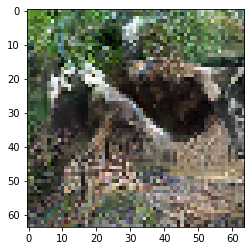

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 19

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 19.690708875656128 sec
Gen loss: 1.3653060890907465, Disc loss: 1.1300626497629076, Disc valid real loss: 0.5448366349866224, Disc valid fake loss: 0.5147112278744231, Disc class real loss: 0.03219010093856246, Disc class fake loss: 0.03832468118885435
Time for epoch 2 is 19.615737199783325 sec
Gen loss: 1.396652537029843, Disc loss: 1.1270337485989859, Disc valid real loss: 0.5343842837353086, Disc valid fake loss: 0.5116480812430382, Disc class real loss: 0.03218172441572892, Disc class fake loss: 0.04881966121713557
Time for epoch 3 is 19.668848514556885 sec
Gen loss: 1.3716055695400682, Disc loss: 1.1089716415072597, Disc valid real loss: 0.5320019602429035, Disc valid fake loss: 0.510972457049891, Disc class real loss: 0.029483224221579337, Disc class fake loss: 0.036514006852799805
Time for epoch 4 is 19.611759662628174 sec
Gen loss: 1.384839226

Time for epoch 31 is 19.485126972198486 sec
Gen loss: 1.3870679569798847, Disc loss: 1.1215702468572661, Disc valid real loss: 0.5412691764013712, Disc valid fake loss: 0.5098250768212385, Disc class real loss: 0.03080902044270218, Disc class fake loss: 0.039666973056820244
Time for epoch 32 is 19.47981595993042 sec
Gen loss: 1.3939315045988836, Disc loss: 1.105335457380428, Disc valid real loss: 0.5375368752798368, Disc valid fake loss: 0.5010328450521757, Disc class real loss: 0.029652453825535705, Disc class fake loss: 0.037113283940375684
Time for epoch 33 is 19.486018896102905 sec
Gen loss: 1.3995553747166034, Disc loss: 1.1085769430149433, Disc valid real loss: 0.5363404004033222, Disc valid fake loss: 0.5029546677373177, Disc class real loss: 0.026247280155176182, Disc class fake loss: 0.04303459568335563
Time for epoch 34 is 19.500611782073975 sec
Gen loss: 1.387417505646861, Disc loss: 1.1219871113466662, Disc valid real loss: 0.5391620766631392, Disc valid fake loss: 0.505313

Time for epoch 61 is 19.546093940734863 sec
Gen loss: 1.4117652226326078, Disc loss: 1.1075721265271652, Disc valid real loss: 0.5299721431247023, Disc valid fake loss: 0.507763647062834, Disc class real loss: 0.030025596902062315, Disc class fake loss: 0.03981073964982792
Time for epoch 62 is 19.559924125671387 sec
Gen loss: 1.4035077843555184, Disc loss: 1.1160534533650377, Disc valid real loss: 0.5367206939777662, Disc valid fake loss: 0.5031057672445164, Disc class real loss: 0.03449681271652924, Disc class fake loss: 0.04173018265553469
Time for epoch 63 is 19.558300256729126 sec
Gen loss: 1.4108385984287706, Disc loss: 1.0931400140357572, Disc valid real loss: 0.5260051736651465, Disc valid fake loss: 0.49479924662168634, Disc class real loss: 0.022934310970635294, Disc class fake loss: 0.049401283654777556
Time for epoch 64 is 19.601177215576172 sec
Gen loss: 1.4201684843662172, Disc loss: 1.1105451452177624, Disc valid real loss: 0.5419406951513401, Disc valid fake loss: 0.5031

Time for epoch 91 is 19.50498127937317 sec
Gen loss: 1.4043353227681892, Disc loss: 1.1060943094103834, Disc valid real loss: 0.5386846379138702, Disc valid fake loss: 0.5086499747148779, Disc class real loss: 0.021356352398385733, Disc class fake loss: 0.037403342058136925
Time for epoch 92 is 19.48958945274353 sec
Gen loss: 1.3854981099450312, Disc loss: 1.1099002690509308, Disc valid real loss: 0.5309687615480534, Disc valid fake loss: 0.5070682185333829, Disc class real loss: 0.027719268071323737, Disc class fake loss: 0.04414402108176186
Time for epoch 93 is 19.496044874191284 sec
Gen loss: 1.3868121560229811, Disc loss: 1.1170806954073351, Disc valid real loss: 0.5373254820357921, Disc valid fake loss: 0.5056379453040832, Disc class real loss: 0.028889306360957392, Disc class fake loss: 0.04522796141948273
Time for epoch 94 is 19.48355984687805 sec
Gen loss: 1.397165839755258, Disc loss: 1.0801358475934628, Disc valid real loss: 0.5282650536229444, Disc valid fake loss: 0.4984961

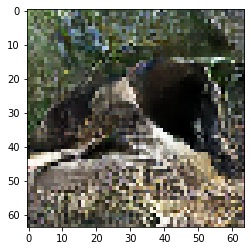

In [34]:
print(label)
next_starting_checkpoint, totalepochs, warmup = long_train(starting_checkpoint=next_starting_checkpoint, 
                                      num_checkpoints=20, 
                                      checkpoint_interval=100, 
                                      g_hist=gen_loss_hist, 
                                      d_hist=disc_loss_hist,
                                      d_real_hist=disc_loss_real_hist,
                                      d_fake_hist=disc_loss_fake_hist,
                                      d_class_real_hist=disc_class_loss_real_hist,
                                      d_class_fake_hist=disc_class_loss_fake_hist,
                                      noise=noise100,
                                      label=label,
                                      save_files=True,
                                      warmup=warmup)

['chihuahua', 'chimpanzee', 'dalmatian', 'dolphin', 'fox', 'giant+panda', 'giraffe', 'otter', 'polar+bear', 'zebra']


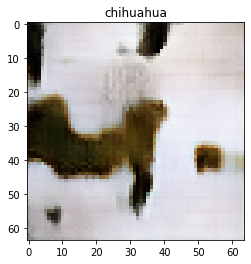

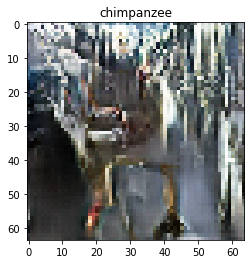

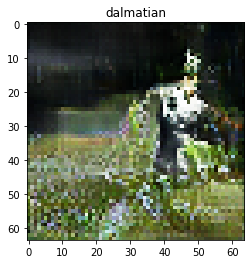

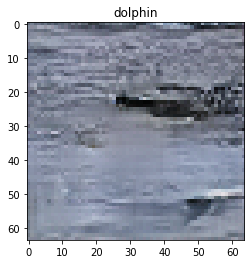

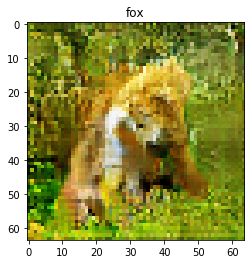

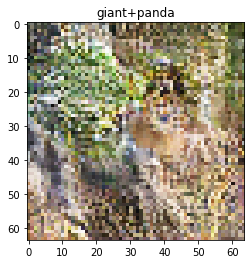

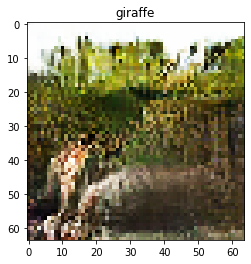

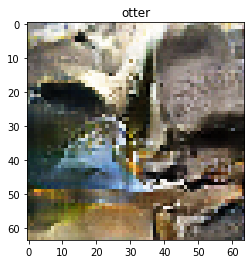

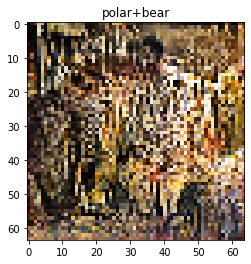

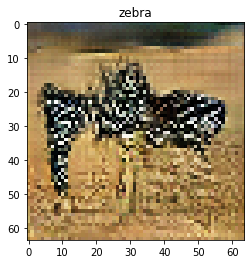

In [40]:
print(img_classes)
# cls = 5
noise = np.random.normal(0, 1, 100)
for label in range(10):
    generated_image = generator.predict([np.array([noise]), np.array([label])] )[0]
    plt.imshow(unnormalize_img(generated_image))
    plt.title(img_classes[label])
    plt.show()

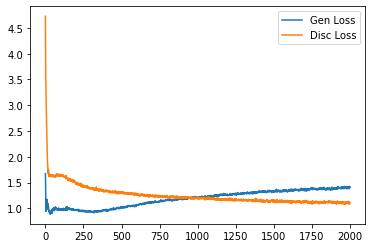

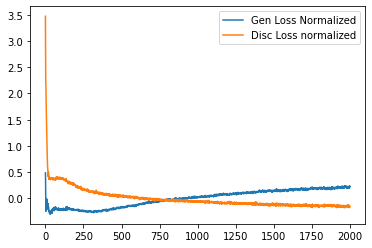

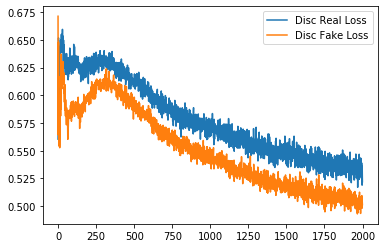

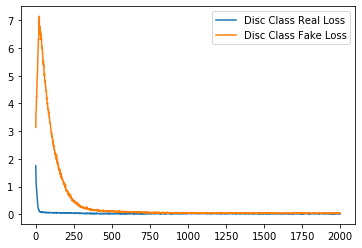

In [35]:
plt.plot(gen_loss_hist)
plt.plot(disc_loss_hist)

plt.legend(['Gen Loss','Disc Loss'])
plt.show()

plt.plot(gen_loss_hist - np.mean(gen_loss_hist))
plt.plot(disc_loss_hist - np.mean(disc_loss_hist))
plt.legend(['Gen Loss Normalized','Disc Loss normalized'])
plt.show()

plt.plot(disc_loss_real_hist)
plt.plot(disc_loss_fake_hist)
plt.legend(['Disc Real Loss','Disc Fake Loss'])
plt.show()

plt.plot(disc_class_loss_real_hist)
plt.plot(disc_class_loss_fake_hist)
plt.legend(['Disc Class Real Loss', 'Disc Class Fake Loss'])
plt.show()


In [ ]:
noise = tf.random.truncated_normal([32, 100])
tf.dtypes.cast(noise, tf.int32)


In [ ]:
for i in range(20,30):
    plt.imshow(unnormalize_img(train_imgs[i]))
    plt.title(img_classes[int(train_classes[i])])
    plt.show()

In [ ]:
intermediate_layer_model = Model(inputs=generator.input[1],
                                 outputs=generator.layers[2].output)


In [ ]:
total = None
for label in range(10):
    if total is None:
        total = np.abs(intermediate_layer_model.predict(np.array([label]))[0][0])
    total += np.abs(intermediate_layer_model.predict(np.array([label]))[0][0])
print(total)

In [ ]:
intermediate_layer_model.predict(np.array([0]))[0][0]

In [ ]:
test_gen = make_generator_model((100,))

In [ ]:
test_gen_embedding = Model(inputs=test_gen.input[1],
                                 outputs=test_gen.layers[2].output)

In [ ]:
test_gen_embedding.predict(np.array([7]))[0][0]

In [ ]:
generator.save_weights('./results/weights/animal-gan-conditional-10-samples-bigger/gen_weights_conditional_10_samples_bigger_' + str(2000) + '.h5')
discriminator.save_weights('./results/weights/animal-gan-conditional-10-samples-bigger/disc_weights_conditional_10_samples_bigger_' + str(2000) + '.h5')

0.0